# **About**

### **Arabic Diacritization**

This project aims to develop and compare different models for Arabic diacritization, a crucial task in natural language processing for the Arabic language. The project explores the use of various deep learning architectures, including biLSTM, CBHG + HMM, and HMM alone to predict the correct diacritics for Arabic text.

**Team Members:**

* Ayman Sahyoun - 202110003
* Mohannad AlBasyouni - 202010589
* Aws AlHantouli - 202110250

--------------


#### 1. **HMM**: Our first model, Hidden Markov Model (HMM) alone, is a statistical model that uses a Markov chain to predict the most likely sequence of diacritics for a given Arabic text.
- Used 5-gram model
- Word Error Rate (WER): ~33.30%
- Diacritization Error Rate (DER): ~66.70%
- Reference: [Anwarvic/Arabic-Tashkeela-Model](https://github.com/Anwarvic/Arabic-Tashkeela-Model)

#### 2. **CBHG + HMM**: Our second model, the Convolutional Neural Network (CNN) - Bidirectional Gated Recurrent Unit (GRU) - Hidden Markov Model (HMM) hybrid model combines the strengths of deep learning and traditional machine learning to achieve high accuracy in diacritization.
- Epochs: 20
- Word Error Rate (WER): ~19.24%
- Diacritization Error Rate (DER): ~24.68%
- Reference: [almodhfer/Arabic_Diacritization](https://github.com/almodhfer/Arabic_Diacritization)

#### 3. **BiLSTM**: Our third model, Bidirectional Long Short-Term Memory (BiLSTM), is a type of recurrent neural network that uses two LSTM layers to learn the patterns in Arabic text and predict diacritics.
- Epochs: 2
- Average Training Loss: ~0.0210
- Average Validation Loss: ~0.0141
- Reference: [MAHMOUDRR707/Arabic-Diacritization-Text](https://github.com/MAHMOUDRR707/Arabic-Diacritization-Text)

#### 4. **RNN-Based**: Our fourth (simple) model, Recurrent Neural Network-Based, is a derivative of the BiLSTM model base, but now with actual testing and evaluation values
- Epochs: 5
- Word Error Rate (WER): ~81.05%
- Diacritization Error Rate (DER): ~18.95%
- Reference: [MAHMOUDRR707/Arabic-Diacritization-Text](https://github.com/MAHMOUDRR707/Arabic-Diacritization-Text)
--------------

### Imports

In [ ]:
!pip install pandas numpy>=1.24.0 matplotlib seaborn plotly wordcloud arabic-reshaper python-bidi nltk jupyter arabic-reshaper[with-fonttools] fonttools graphviz

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.


In [ ]:
import time
import random
import numpy as np
import pickle
import pandas as pd
import nltk
import os
from collections import Counter
import json

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud

#PreProcessing
import re
from glob import glob

#Combined Model (CBHG + HMM)
from typing import Optional, List, Dict, Tuple, Union, Any
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
from torch.optim import Adam  # Correct PyTorch Adam optimizer import
from torch.utils.data import DataLoader
from collections import defaultdict, deque
from enum import Enum

#LSTM
from tensorflow.keras.utils import to_categorical # for the LSTM it will be used to convert the diacritics integers to one-hot encodings.
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional, GRU, TimeDistributed , Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load the required dependancies
WITH_EXTRA_TRAIN = False

with open('/content/ARABIC_LETTERS_LIST.pickle', 'rb') as file:  #Contains a list of Arabic letters
    ARABIC_LETTERS_LIST = pickle.load(file)
with open('/content/DIACRITICS_LIST.pickle', 'rb') as file:  #Contains a list of all diacritics
    DIACRITICS_LIST = pickle.load(file)
if not WITH_EXTRA_TRAIN:
    with open('/content/RNN_SMALL_CHARACTERS_MAPPING.pickle', 'rb') as file:  #Contains a dictionary, mapping each diactritics class to its unique integer
        CHARACTERS_MAPPING = pickle.load(file)
else:
    with open('/content/RNN_BIG_CHARACTERS_MAPPING.pickle', 'rb') as file:  #Contains a dictionary, mapping each integer to its unique diactritics class
        CHARACTERS_MAPPING = pickle.load(file)
with open('/content/RNN_CLASSES_MAPPING.pickle', 'rb') as file:  #Contains a dictionary, mapping each character to its unique integer (Without using using the extra training dataset)
    CLASSES_MAPPING = pickle.load(file)
with open('/content/RNN_REV_CLASSES_MAPPING.pickle', 'rb') as file:  #Contains a dictionary, mapping each character to its unique integer (Using using the extra training dataset)
    REV_CLASSES_MAPPING = pickle.load(file)

In [ ]:
if not os.path.exists('/content/raw_data'):
    os.makedirs('/content/raw_data')

!mv /content/train.txt /content/raw_data/


# Read the data that will be used for training
train_raw = None
with open('/content/raw_data/train.txt', 'r') as file:
    train_raw = file.readlines()

# Read the data that will be used for validation
val_raw = None
with open('/content/val.txt', 'r') as file:
    val_raw = file.readlines()

###EDA & Visuals

In [ ]:
def load_and_process_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    entries = [e for e in text.split('\n') if e.strip()]

    df = pd.DataFrame({
        'text': entries,
        'length': [len(e) for e in entries],
        'is_arabic': [any('\u0600' <= c <= '\u06FF' for c in e) for e in entries],
        'word_count': [len(e.split()) for e in entries]
    })

    return df

df = load_and_process_text("/content/raw_data/train.txt")
df.head()

,text,length,is_arabic,word_count
0,وَلَوْ جَمَعَ ثُمَّ عَلِمَ تَرْكَ رُكْنٍ مِنْ ...,226,True,30
1,قَالَ أَبُو زَيْدٍ أَهْلُ تِهَامَةَ يُؤَنِّثُو...,162,True,21
2,بِمَنْزِلَةِ أَهْلِ الذِّمَّةِ إذَا دَخَلُوا ق...,178,True,23
3,الْمَسْأَلَةُ الْخَامِسَةُ قَوْله تَعَالَى : {...,408,True,55
4,قَوْلُهُ ( وَاَلَّذِي لَا يَتَغَابَنُ النَّاسُ...,553,True,75


In [ ]:
def visualize_patterns(df):
    """Create pattern visualizations using Plotly"""
    # Calculate various text patterns
    pattern_data = {
        'Has numbers': df['text'].str.contains('\d').sum(),
        'Has parentheses': df['text'].str.contains('[()]').sum(),
        'Has punctuation': df['text'].str.contains('[،.:؛]').sum(),
        'Pure Arabic': df['is_arabic'].sum()
    }

    fig = px.sunburst(
        names=list(pattern_data.keys()),
        parents=[''] * len(pattern_data),
        values=list(pattern_data.values()),
        title='Text Pattern Distribution'
    )

    return fig

visualize_patterns(df).show()

In [ ]:
summary = {
    'Total Entries': len(df),
    'Average Length': df['length'].mean(),
    'Average Word Count': df['word_count'].mean(),
    'Max Length': df['length'].max(),
    'Min Length': df['length'].min()
}

fig = go.Figure(data=[go.Table(
    header=dict(values=['Metric', 'Value'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[list(summary.keys()),
                      [f"{v:.2f}" if isinstance(v, float) else v for v in summary.values()]],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title='Text Analysis Summary')
fig.show()

In [ ]:
fig = px.histogram(df, x='length',
                  title='Distribution of Text Lengths',
                  nbins=50,
                  color='is_arabic',
                  labels={'length': 'Text Length', 'count': 'Frequency'})
fig.show()

In [ ]:
def preprocess_arabic_text(text):
    """Reshape Arabic text for proper display"""
    # Remove punctuation and special characters
    punctuation = '،.:;!؟()[]{}«»\'"'
    text = ''.join(ch for ch in text if ch not in punctuation)

    # Reshape and handle RTL
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

def analyze_arabic_text(df):
    """Analyze Arabic text content"""
    # Filter Arabic text
    arabic_texts = df[df['is_arabic']]['text'].tolist()

    # Tokenize and count words, excluding punctuation and single characters
    all_words = []
    for text in arabic_texts:
        words = text.split()
        for word in words:
            # Check if word contains Arabic characters and is longer than 1 character
            if any('\u0600' <= c <= '\u06FF' for c in word) and len(word) > 1:
                # Remove punctuation
                word = ''.join(ch for ch in word if '\u0600' <= ch <= '\u06FF' or ch == ' ')
                if word.strip():  # Only add non-empty words
                    all_words.append(word)

    word_freq = Counter(all_words).most_common(10)


    words, counts = zip(*word_freq)
    words = [preprocess_arabic_text(w) for w in words]

    fig = go.Figure(data=[go.Bar(
        x=words[::-1],
        y=counts[::-1],
        text=counts[::-1],
        textposition='auto',
    )])

    fig.update_layout(
        title='Most Common Arabic Words',
        xaxis_tickangle=-45,
        height=500,
        font=dict(size=14),
        xaxis=dict(
            autorange='reversed',
            tickfont=dict(size=12)
        )
    )

    return fig

analyze_arabic_text(df).show()

###Preprocessing **(For Pure HMM and CBHG + HMM)**

In [ ]:
def clean_text(text):
    text = re.sub(r"[-()\"#/@;:_<>{}`﴾﴿ے+=~&|.!?,a-zA-Z0-9٠-٩]", "", text)
    return text

def remove_diacritics(data_raw):
  return data_raw.translate(str.maketrans('', '', ''.join(DIACRITICS_LIST)))

In [ ]:
class ArabicPreprocessor:
    """Preprocessor for Arabic diacritization data"""

    def __init__(self, base_dir: str = "arabic_data"):
        # Define main directories
        self.DIACRITICS_LIST = re.compile(f"[{''.join(DIACRITICS_LIST)}]")
        self.base_dir = base_dir
        self.train_dir = os.path.join(base_dir, "train")
        self.test_dir = os.path.join(base_dir, "test")
        self.val_dir = os.path.join(base_dir, "val")

        # Create directories if they don't exist
        for directory in [self.base_dir, self.train_dir, self.test_dir, self.val_dir]:
            os.makedirs(directory, exist_ok=True)

    def clean_text(self, text: str) -> str:
        """Clean the text by removing unwanted characters"""
        text = re.sub(r"[-()\"#/@;:_<>{}`﴾﴿ے+=~&|.!?,a-zA-Z0-9٠-٩]", "", text)
        return text

    def split_into_words(self, text: str) -> List[str]:
        """Split text into words and filter empty ones"""
        return [word for word in text.split() if word.strip()]

    def is_diacritized(self, word: str) -> bool:
        """Check if a word contains diacritics"""
        return bool(self.DIACRITICS_LIST.search(word))

    def process_file(self, file_path: str) -> List[Dict[str, str]]:
        """Process a single file and return list of word pairs"""
        processed_words = []

        try:
            # Try different encodings
            encodings = ['utf-8', 'utf-8-sig', 'cp1256', 'arabic']
            text = None

            for encoding in encodings:
                try:
                    with open(file_path, 'r', encoding=encoding) as f:
                        text = f.read()
                    break
                except UnicodeDecodeError:
                    continue

            if text is None:
                # If all encodings fail, try binary mode
                with open(file_path, 'rb') as f:
                    text = f.read().decode('utf-8', errors='ignore')

            # Clean text before processing
            cleaned_text = self.clean_text(text)

            words = self.split_into_words(cleaned_text)

            for word in words:
                if self.is_diacritized(word):
                    # Create clean version (without diacritics)
                    clean_word = self.DIACRITICS_LIST.sub('', word)
                    processed_words.append({
                        'diacritized': word,
                        'clean': clean_word
                    })

            print(f"Processed {len(processed_words)} words from {file_path}")

        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")

        return processed_words

    def save_words(self, words: List[Dict[str, str]], output_file: str):
        """Save processed words to file"""
        try:
            with open(output_file, 'w', encoding='utf-8') as f:
                for word in words:
                    f.write(f"{word['diacritized']}\n")
            print(f"Saved {len(words)} words to {output_file}")
        except Exception as e:
            print(f"Error saving to {output_file}: {str(e)}")

    def process_data(self,
                     input_dir: str,
                     train_ratio: float = 0.8,
                     val_ratio: float = 0.1,
                     test_ratio: float = 0.1):
        """Process all files and split into train/val/test sets"""
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9, "Ratios must sum to 1"

        # Get all text files
        files = []
        for ext in ['.txt']:  # Add more extensions if needed
            files.extend(glob(os.path.join(input_dir, f"**/*{ext}"), recursive=True))

        if not files:
            raise ValueError(f"No text files found in {input_dir}")

        print(f"Found {len(files)} files to process")

        # Process files
        all_words = []
        for file_path in files:
            words = self.process_file(file_path)
            if words:  # Only add if we got some words
                all_words.extend(words)

        if not all_words:
            raise ValueError("No diacritized words found in input files")

        print(f"Processed {len(all_words)} words total")

        # Split data
        train_end = int(len(all_words) * train_ratio)
        val_end = int(len(all_words) * (train_ratio + val_ratio))

        train_words = all_words[:train_end]
        val_words = all_words[train_end:val_end]
        test_words = all_words[val_end:]

        # Save splits
        self.save_words(train_words, os.path.join(self.train_dir, "train.txt"))
        self.save_words(val_words, os.path.join(self.val_dir, "val.txt"))
        self.save_words(test_words, os.path.join(self.test_dir, "test.txt"))

        # Save clean versions for test set
        with open(os.path.join(self.test_dir, "test_clean.txt"), 'w', encoding='utf-8') as f:
            for word in test_words:
                f.write(f"{word['clean']}\n")

        print(f"Saved {len(train_words)} training words")
        print(f"Saved {len(val_words)} validation words")
        print(f"Saved {len(test_words)} test words")

        # Verify files were created and have content
        for file_path in [
            os.path.join(self.train_dir, "train.txt"),
            os.path.join(self.val_dir, "val.txt"),
            os.path.join(self.test_dir, "test.txt"),
            os.path.join(self.test_dir, "test_clean.txt")
        ]:
            if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
                raise ValueError(f"Failed to create or populate {file_path}")

def preprocess_arabic_data(
    input_dir: str = "raw_data",
    output_dir: str = "arabic_data",
    train_ratio: float = 0.8,
    val_ratio: float = 0.1,
    test_ratio: float = 0.1
):
    """Convenience function to preprocess data"""
    preprocessor = ArabicPreprocessor(output_dir)
    preprocessor.process_data(
        input_dir=input_dir,
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        test_ratio=test_ratio
    )
    return preprocessor

if __name__ == "__main__":
    # Example usage
    try:
        preprocessor = preprocess_arabic_data(
            input_dir="raw_data",
            output_dir="arabic_data"
        )
        print("Preprocessing completed successfully!")
    except Exception as e:
        print(f"Preprocessing failed: {str(e)}")


Found 1 files to process
Processed 2093147 words from raw_data/train.txt
Processed 2093147 words total
Saved 1674517 words to arabic_data/train/train.txt
Saved 209315 words to arabic_data/val/val.txt
Saved 209315 words to arabic_data/test/test.txt
Saved 1674517 training words
Saved 209315 validation words
Saved 209315 test words
Preprocessing completed successfully!


In [ ]:
def load_and_process_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    entries = [e for e in text.split('\n') if e.strip()]

    df = pd.DataFrame({
        'text': entries,
        'length': [len(e) for e in entries],
        'is_arabic': [any('\u0600' <= c <= '\u06FF' for c in e) for e in entries],
        'word_count': [len(e.split()) for e in entries]
    })

    return df

df = load_and_process_text("/content/arabic_data/train/train.txt")
df.head()

,text,length,is_arabic,word_count
0,وَلَوْ,6,True,1
1,جَمَعَ,6,True,1
2,ثُمَّ,5,True,1
3,عَلِمَ,6,True,1
4,تَرْكَ,6,True,1


In [ ]:
def visualize_patterns(df):
    """Create pattern visualizations using Plotly"""
    # Calculate various text patterns
    pattern_data = {
        'Has numbers': df['text'].str.contains('\d').sum(),
        'Has parentheses': df['text'].str.contains('[()]').sum(),
        'Has punctuation': df['text'].str.contains('[،.:؛]').sum(),
        'Pure Arabic': df['is_arabic'].sum() # this can be removed
    }

    # Create sunburst chart
    fig = px.sunburst(
        names=list(pattern_data.keys()),
        parents=[''] * len(pattern_data),
        values=list(pattern_data.values()),
        title='Text Pattern Distribution'
    )

    return fig

visualize_patterns(df).show()

## Pure HMM **(5-gram)**

In [ ]:
class HMM:
    """Hidden Markov Model for Arabic diacritization"""

    def __init__(self, n: int = 5, model_dir: str = "models"):
        """
        Initialize HMM model
        Args:
            n: n-gram size (default: 3)
            model_dir: directory to save/load model files
        """
        assert n >= 2, "n-gram size must be >= 2"

        self.n = n
        self.model_dir = model_dir
        os.makedirs(model_dir, exist_ok=True)

        # Model constants
        self.START = '*'
        self.NULL_TAG = 'O'  # Tag for non-diacritized characters

        # Define possible diacritic states
                # Define possible diacritic states
        self.STATES = {
            # Basic diacritics
            'ُ', 'َ', 'ِ',      # Damma, Fatha, Kasra
            'ْ', 'ّ',          # Sukoon, Shadda
            'ٌ', 'ً', 'ٍ',      # Tanween (Double) Damma, Fatha, Kasra

            # Shadda combinations
            'َّ', 'ُّ', 'ِّ',    # Shadda + Basic
            'ّْ',              # Shadda + Sukoon
            'ٌّ', 'ًّ', 'ٍّ',    # Shadda + Tanween

            # Additional combinations
            'ْٰ', 'ٰ',         # Superscript Alef
            'ٖ', 'ٗ',         # Other diacritics

            'O'               # No diacritic
        }

        # Initialize or load n-gram model
        self.model_path = os.path.join(model_dir, f"{n}gram_model.pkl")
        self.character_ngram = self._load_model()

    def _load_model(self) -> Dict:
        """Load existing model or create new one"""
        try:
            with open(self.model_path, 'rb') as f:
                model = pickle.load(f)
                print(f"Loaded existing {self.n}-gram model")
                return model
        except FileNotFoundError:
            print(f"Creating new {self.n}-gram model")
            return defaultdict(int)

    def _save_model(self):
        """Save model to disk"""
        with open(self.model_path, 'wb') as f:
            pickle.dump(self.character_ngram, f)
        print(f"Saved model to {self.model_path}")

    def load_trained_model(self, model_path: str):
        """Load a pre-trained model from a .pkl file"""
        with open(model_path, 'rb') as f:
            self.character_ngram = pickle.load(f)
        print(f"Loaded pre-trained {self.n}-gram model from {model_path}")
        return self

    def test_on_sentences(self, sentences: list):
        """
        Test the model on a list of sentences
        Args:
            sentences: list of sentences (words) to diacritize
        Returns:
            List of diacritized sentences
        """
        diacritized_sentences = []
        for sentence in sentences:
            diacritized_sentence = self.diacritize_word(sentence)
            diacritized_sentences.append(diacritized_sentence)
        return diacritized_sentences

    def _extract_character_diacritic_pairs(self, word: str) -> List[Tuple[str, str]]:
        """Extract character-diacritic pairs from a word"""
        pairs = []
        current_char = ""
        current_diacritics = ""

        for char in word:
            if char in self.STATES:
                current_diacritics += char
            else:
                if current_char:
                    pairs.append((current_char,
                                current_diacritics if current_diacritics else self.NULL_TAG))
                current_char = char
                current_diacritics = ""

        # Handle last character
        if current_char:
            pairs.append((current_char,
                         current_diacritics if current_diacritics else self.NULL_TAG))

        return pairs

    def train(self, train_file: str):
        """
        Train the HMM model on diacritized text
        Args:
            train_file: path to training file with diacritized words
        """
        print(f"Training {self.n}-gram model...")
        num_words = 0
        num_errors = 0

        with open(train_file, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip()
                if not word:
                    continue

                try:
                    # Extract character-diacritic pairs
                    pairs = self._extract_character_diacritic_pairs(word)
                    chars, diacritics = zip(*pairs)

                    # Update n-gram counts
                    d = deque(self.START * (self.n-1), maxlen=self.n-1)
                    for char, diacritic in zip(chars, diacritics):
                        self.character_ngram[(*d, char), diacritic] += 1
                        d.append(char)
                    num_words += 1
                except Exception as e:
                    num_errors += 1
                    print(f"Error processing word '{word}': {str(e)}")

        self._save_model()
        print(f"Processed {num_words} words with {num_errors} errors")

    def diacritize_word(self, word: str) -> str:
        """
        Add diacritics to a word using the trained model
        Args:
            word: clean word without diacritics
        Returns:
            Diacritized word
        """
        d = deque(self.START * (self.n-1), maxlen=self.n-1)
        result = []

        for char in word:
            # Find most likely diacritic
            best_diacritic = self.NULL_TAG
            best_count = 0

            for diacritic in self.STATES:
                count = self.character_ngram[(*d, char), diacritic]
                if count > best_count:
                    best_diacritic = diacritic
                    best_count = count

            # Add character and diacritic
            result.append(char)
            if best_diacritic != self.NULL_TAG:
                result.append(best_diacritic)

            d.append(char)

        return ''.join(result)

    def diacritize_sentence(self, sentence: str) -> str:
      if not sentence.strip():
          return ""  # Handle empty or whitespace-only sentences

      # Split the sentence into words
      words = sentence.split()

      # Diacritize each word
      diacritized_words = []
      for word in words:
          try:
              # Assume `diacritize_word` is an existing method or replace with your word-level logic
              diacritized_word = self.diacritize_word(word)
              diacritized_words.append(diacritized_word)
          except Exception as e:
              print(f"Error diacritizing word '{word}': {e}")
              diacritized_words.append(word)  # Keep original word if error occurs

      # Rejoin words into a diacritized sentence
      return " ".join(diacritized_words)

    def diacritize_text(self, input_file: str, output_file: str):
        """
        Diacritize all words in a file
        Args:
            input_file: path to input file with clean words
            output_file: path to save diacritized words
        """
        with open(input_file, 'r', encoding='utf-8') as fin, \
             open(output_file, 'w', encoding='utf-8') as fout:

            for line in fin:
                word = line.strip()
                if word:
                    diacritized = self.diacritize_word(word)
                    fout.write(f"{diacritized}\n")
                else:
                    fout.write("\n")

if __name__ == "__main__":
    hmm = HMM(n=5)
    hmm.train("arabic_data/train/train.txt")

    test_word = "اللغة العربية جميلة"
    predicted = hmm.diacritize_sentence(test_word)
    print(f"Input: {test_word}")
    print(f"Prediction: {predicted}")

    hmm.diacritize_text(
        "arabic_data/test/test_clean.txt",
        "arabic_data/test/test_predictions.txt"
    )

Creating new 5-gram model
Training 5-gram model...
Saved model to models/5gram_model.pkl
Processed 1674517 words with 0 errors
Input: اللغة العربية جميلة
Prediction: الْلّغَةِ الْعَرَبِيةِ جَمِيلَةً


## CBHG + HMM Model

### Text Encoders

In [ ]:
from typing import Optional, List, Dict, Tuple, Union, Any
from torch.utils.data import Dataset
from tqdm import tqdm
def basic_cleaners(text: str) -> str:
    """Basic Arabic text cleaning - keeps only valid Arabic characters"""
    # Define valid Arabic characters
    valid_chars = "بض.غىهظخة؟:طس،؛فندؤلوئآك-يذاصشحزءمأجإ ترقعث"
    return ''.join(c for c in text if c in valid_chars)

class TextEncoder:
    pad = "P"

    def __init__(
        self,
        input_chars: List[str],
        target_charts: List[str],
        cleaner_fn: Optional[str] = None,
        reverse_input: bool = False,
        reverse_target: bool = False,
    ):
        # Instead of dynamic import, use direct function reference
        if cleaner_fn == "basic_cleaners":
            self.cleaner_fn = basic_cleaners
        else:
            self.cleaner_fn = None

        self.input_symbols: List[str] = [TextEncoder.pad] + input_chars
        # Add 'O' to target symbols if not present
        if 'O' not in target_charts:
            target_charts = ['O'] + target_charts
        self.target_symbols: List[str] = [TextEncoder.pad] + target_charts

        self.input_symbol_to_id: Dict[str, int] = {
            s: i for i, s in enumerate(self.input_symbols)
        }
        self.input_id_to_symbol: Dict[int, str] = {
            i: s for i, s in enumerate(self.input_symbols)
        }

        self.target_symbol_to_id: Dict[str, int] = {
            s: i for i, s in enumerate(self.target_symbols)
        }
        self.target_id_to_symbol: Dict[int, str] = {
            i: s for i, s in enumerate(self.target_symbols)
        }

        self.reverse_input = reverse_input
        self.reverse_target = reverse_target
        self.input_pad_id = self.input_symbol_to_id[self.pad]
        self.target_pad_id = self.target_symbol_to_id[self.pad]
        self.start_symbol_id = None

    def input_to_sequence(self, text: str) -> List[int]:
        """Convert input text to sequence of indices"""
        if self.cleaner_fn:
            text = self.cleaner_fn(text)

        if self.reverse_input:
            text = text[::-1]

        sequence = []
        for char in text:
            if char in self.input_symbol_to_id:
                sequence.append(self.input_symbol_to_id[char])
        return sequence

    def target_to_sequence(self, text: str) -> List[int]:
        """Convert target text to sequence of indices"""
        if self.reverse_target:
            text = text[::-1]

        sequence = []
        for char in text:
            if char in self.target_symbol_to_id:
                sequence.append(self.target_symbol_to_id[char])
        return sequence

    def sequence_to_input(self, sequence: List[int]) -> str:
        """Convert sequence of indices back to input text"""
        text = ''.join([
            self.input_id_to_symbol[idx]
            for idx in sequence
            if idx in self.input_id_to_symbol and idx != self.input_pad_id
        ])

        if self.reverse_input:
            text = text[::-1]
        return text

    def sequence_to_target(self, sequence: List[int]) -> str:
        """Convert sequence of indices back to target text"""
        text = ''.join([
            self.target_id_to_symbol[idx]
            for idx in sequence
            if idx in self.target_id_to_symbol and idx != self.target_pad_id
        ])

        if self.reverse_target:
            text = text[::-1]
        return text

    def combine_text_and_haraqat(self, input_ids: List[int], output_ids: List[int]) -> str:
        """Combine input text with diacritics"""
        input_text = self.sequence_to_input(input_ids)
        output_text = self.sequence_to_target(output_ids)

        result = ""
        for i, char in enumerate(input_text):
            result += char
            if i < len(output_text) and output_text[i] != 'O':
                result += output_text[i]
        return result

class BasicArabicEncoder(TextEncoder):
    def __init__(
        self,
        cleaner_fn="basic_cleaners",
        reverse_input: bool = False,
        reverse_target: bool = False,
    ):
        input_chars: List[str] = list("بض.غىهظخة؟:طس،؛فندؤلوئآك-يذاصشحزءمأجإ ترقعث")
        target_charts: List[str] = ['ٌ', 'ً', 'ٍ', 'ُ', 'َ', 'ِ', 'ْ', 'ّ', 'ٌّ', 'ًّ', 'ٍّ', 'ُّ', 'َّ', 'ِّ', 'ّْ']

        super().__init__(
            input_chars,
            target_charts,
            cleaner_fn=cleaner_fn,
            reverse_input=reverse_input,
            reverse_target=reverse_target,
        )

class ArabicEncoderWithStartSymbol(TextEncoder):
    def __init__(
        self,
        cleaner_fn="basic_cleaners",
        reverse_input: bool = False,
        reverse_target: bool = False,
    ):
        input_chars: List[str] = list("بض.غىهظخة؟:طس،؛فندؤلوئآك-يذاصشحزءمأجإ ترقعث")

        # Extended list of diacritics including all possible combinations
        target_charts: List[str] = [
            # Basic diacritics
            'ُ', 'َ', 'ِ',      # Damma, Fatha, Kasra
            'ْ', 'ّ',          # Sukoon, Shadda
            'ٌ', 'ً', 'ٍ',      # Tanween (Double) Damma, Fatha, Kasra

            # Shadda combinations
            'َّ', 'ُّ', 'ِّ',    # Shadda + Basic
            'ّْ',              # Shadda + Sukoon
            'ٌّ', 'ًّ', 'ٍّ',    # Shadda + Tanween

            # Additional combinations
            'ْٰ', 'ٰ',         # Superscript Alef
            'ٖ', 'ٗ',         # Other diacritics

            # Start symbol
            's'
        ]

        super().__init__(
            input_chars,
            target_charts,
            cleaner_fn=cleaner_fn,
            reverse_input=reverse_input,
            reverse_target=reverse_target,
        )

        self.start_symbol_id = self.target_symbol_to_id["s"]

### Utils

In [ ]:
def word_iterator(word: Optional[str]) -> List[Tuple[str, str]]:
    """
    Extract character-diacritic pairs from a word.
    Handles combined diacritics correctly.
    """
    if word is None:  # Handle None input
        return []

    # Sort by length for proper matching
    DIACRITICS_LIST.sort(key=len, reverse=True)

    output = []
    current_char = ""
    current_diacritics = ""

    for char in word:
        # Check if char is a diacritic or part of a combined diacritic
        is_diacritic = False
        for diacritic in DIACRITICS_LIST:
            if char in diacritic:
                current_diacritics += char
                is_diacritic = True
                break

        if not is_diacritic:
            if current_char:
                # Process any accumulated diacritics
                final_diacritic = ''
                for diacritic in DIACRITICS_LIST:
                    if diacritic in current_diacritics:
                        final_diacritic = diacritic
                        break
                output.append((current_char, final_diacritic if final_diacritic else 'O'))
            current_char = char
            current_diacritics = ""

    # Handle last character
    if current_char:
        final_diacritic = ''
        for diacritic in DIACRITICS_LIST:
            if diacritic in current_diacritics:
                final_diacritic = diacritic
                break
        output.append((current_char, final_diacritic if final_diacritic else 'O'))

    return output


def evaluate_word(gold_word: str, pred_word: str, analysis: bool = False) -> Tuple[float, float]:
    """Evaluate prediction against gold standard"""
    gold_pairs = word_iterator(gold_word)
    pred_pairs = word_iterator(pred_word)

    # Ensure same length
    min_len = min(len(gold_pairs), len(pred_pairs))
    gold_pairs = gold_pairs[:min_len]
    pred_pairs = pred_pairs[:min_len]

    correct = sum(1 for (_, g_d), (_, p_d) in zip(gold_pairs, pred_pairs) if g_d == p_d)
    total = len(gold_pairs)

    if analysis:
        return correct, total
    return correct / total if total > 0 else 0.0

def take_first_n_lines(input_file: str, output_file: str, n: int = 2000):
    try:
        with open(input_file, 'r', encoding='utf-8') as fin:
            lines = [next(fin) for _ in range(n)]  # Read first `n` lines

        with open(output_file, 'w', encoding='utf-8') as fout:
            fout.writelines(lines)  # Write lines to output file

        print(f"Successfully wrote first {n} lines to {output_file}")
    except StopIteration:
        print(f"Input file has less than {n} lines. Writing all available lines.")
        with open(output_file, 'w', encoding='utf-8') as fout:
            fout.writelines(lines)  # Write available lines to output file
    except Exception as e:
        print(f"Error processing file: {e}")

### Dataset Loader

In [ ]:
class ArabicDiacritizationDataset(Dataset):
    """Dataset class for Arabic diacritization data"""

    def __init__(self, data_path: str, max_samples: Optional[int] = None):
        """
        Initialize dataset
        Args:
            data_path: Path to the data file (train.txt, val.txt, etc.)
            max_samples: Maximum number of samples to load (for faster training)
        """
        self.data_path = data_path
        self.max_samples = max_samples
        self.text_encoder = ArabicEncoderWithStartSymbol()
        self.data: List[Dict[str, str]] = []

        # Load and process data file
        self._load_data()

    def _load_data(self):
        """Load data from preprocessed file"""
        try:
            with open(self.data_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()

                # Take subset if max_samples is specified
                if self.max_samples is not None:
                    lines = lines[:self.max_samples]

                # Use tqdm for loading progress
                for line in tqdm(lines, desc=f"Loading {os.path.basename(self.data_path)}"):
                    word = line.strip()
                    if word:  # Skip empty lines
                        # Store both diacritized and clean versions
                        self.data.append({
                            "diacritized": word,
                            "clean": remove_diacritics(word)
                        })
            print(f"Loaded {len(self.data)} words from {self.data_path}")

        except Exception as e:
            print(f"Error loading data from {self.data_path}: {str(e)}")
            raise e

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Get a single item from the dataset
        Returns:
            Dictionary containing:
            - input: tensor of input character indices
            - target: tensor of target diacritic indices
            - raw_text: original diacritized text
        """
        item = self.data[idx]

        # Convert clean text to input sequence
        input_seq = self.text_encoder.input_to_sequence(item["clean"])

        # Get target sequence from diacritized text
        target_seq = []
        for _, diacritic in word_iterator(item["diacritized"]):
            target_seq.append(self.text_encoder.target_symbol_to_id[diacritic])

        # Convert to tensors
        input_tensor = torch.LongTensor(input_seq)
        target_tensor = torch.LongTensor(target_seq)

        return {
            "input": input_tensor,
            "target": target_tensor,
            "raw_text": item["diacritized"],
            "input_len": len(input_seq),
            "target_len": len(target_seq)
        }

    def collate_fn(self, batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        """
        Custom collate function to handle batching
        Args:
            batch: List of individual samples
        Returns:
            Batched tensors with padding
        """
        # Get max sequence length in batch
        max_input_len = max(x["input_len"] for x in batch)
        max_target_len = max(x["target_len"] for x in batch)

        # Prepare tensors
        batch_size = len(batch)
        input_tensor = torch.full(
            (batch_size, max_input_len),
            self.text_encoder.input_pad_id,
            dtype=torch.long
        )
        target_tensor = torch.full(
            (batch_size, max_input_len),  # Make target same length as input
            self.text_encoder.target_pad_id,
            dtype=torch.long
        )

        # Fill tensors
        for i, item in enumerate(batch):
            input_len = item["input_len"]
            target_len = item["target_len"]

            # Ensure target length matches input length
            min_len = min(input_len, target_len)

            input_tensor[i, :min_len] = item["input"][:min_len]
            target_tensor[i, :min_len] = item["target"][:min_len]

        return {
            "input": input_tensor,
            "target": target_tensor,
            "raw_text": [x["raw_text"] for x in batch],
            "lengths": torch.LongTensor([min(x["input_len"], x["target_len"]) for x in batch])
        }

### Attention

In [ ]:
class AttentionType(Enum):
    """Type of attention used during training"""

    LocationSensitive = 1
    Content_Based = 2
    MultiHead = 3


class LearningRateType(Enum):
    """Type of learning rate used during training"""

    Learning_Rate_Decay = 1
    Cosine_Scheduler = 2
    SquareRoot_Scheduler = 3


class OptimizerType(Enum):
    """Type of optimizer used during training"""

    Adam = 1
    SGD = 2
    AdamW = 3


class LossType(Enum):
    """Type of loss function used during training"""

    L1_LOSS = 1
    MSE_LOSS = 2
    L1_LOSS_MASKED = 3
    MSE_LOSS_MASKED = 4
    BOTH = 5
    BOTH_MASKED = 6

In [ ]:
import torch.nn as nn
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim: int, n_heads: int, dropout: float = 0.0):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim * 2, hid_dim)

        if dropout != 0.0:
            self.dropout = nn.Dropout(dropout)

        self.use_dropout = dropout != 0.0
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        device = query.device

        # Move scale to the correct device
        self.scale = self.scale.to(device)

        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q = [batch size, query len, hid dim]
        # K = [batch size, key len, hid dim]
        # V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy = [batch size, n heads, query len, key len]

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)  # Add dims for heads
            energy = energy.masked_fill(mask == 0, -float("inf"))

        attention = torch.softmax(energy, dim=-1)

        # attention = [batch size, n heads, query len, key len]

        if self.use_dropout:
            context_vector = torch.matmul(self.dropout(attention), V)
        else:
            context_vector = torch.matmul(attention, V)

        # x = [batch size, n heads, query len, head dim]

        context_vector = context_vector.permute(0, 2, 1, 3).contiguous()

        # x = [batch size, query len, n heads, head dim]

        context_vector = context_vector.view(batch_size, -1, self.hid_dim)

        x = torch.cat((query, context_vector), dim=-1)

        # x = [batch size, query len, hid dim * 2]

        x = self.fc_o(x)

        # x = [batch size, query len, hid dim]

        return x, attention

###HMM Model (For Combined Model)

In [ ]:
class HMM:
    """Hidden Markov Model for Arabic diacritization"""

    def __init__(self, n: int = 5, model_dir: str = "models"):
        """
        Initialize HMM model
        Args:
            n: n-gram size (default: 3)
            model_dir: directory to save/load model files
        """
        assert n >= 2, "n-gram size must be >= 2"

        self.n = n
        self.model_dir = model_dir
        os.makedirs(model_dir, exist_ok=True)

        # Model constants
        self.START = '*'
        self.NULL_TAG = 'O'  # Tag for non-diacritized characters

        # Define possible diacritic states
                # Define possible diacritic states
        self.STATES = {
            # Basic diacritics
            'ُ', 'َ', 'ِ',      # Damma, Fatha, Kasra
            'ْ', 'ّ',          # Sukoon, Shadda
            'ٌ', 'ً', 'ٍ',      # Tanween (Double) Damma, Fatha, Kasra

            # Shadda combinations
            'َّ', 'ُّ', 'ِّ',    # Shadda + Basic
            'ّْ',              # Shadda + Sukoon
            'ٌّ', 'ًّ', 'ٍّ',    # Shadda + Tanween

            # Additional combinations
            'ْٰ', 'ٰ',         # Superscript Alef
            'ٖ', 'ٗ',         # Other diacritics

            'O'               # No diacritic
        }

        # Initialize or load n-gram model
        self.model_path = os.path.join(model_dir, f"{n}gram_model.pkl")
        self.character_ngram = self._load_model()

    def _load_model(self) -> Dict:
        """Load existing model or create new one"""
        try:
            with open(self.model_path, 'rb') as f:
                model = pickle.load(f)
                print(f"Loaded existing {self.n}-gram model")
                return model
        except FileNotFoundError:
            print(f"Creating new {self.n}-gram model")
            return defaultdict(int)

    def _save_model(self):
        """Save model to disk"""
        with open(self.model_path, 'wb') as f:
            pickle.dump(self.character_ngram, f)
        print(f"Saved model to {self.model_path}")

    def load_trained_model(self, model_path: str):
        """Load a pre-trained model from a .pkl file"""
        with open(model_path, 'rb') as f:
            self.character_ngram = pickle.load(f)
        print(f"Loaded pre-trained {self.n}-gram model from {model_path}")
        return self

    def test_on_sentences(self, sentences: list):
        """
        Test the model on a list of sentences
        Args:
            sentences: list of sentences (words) to diacritize
        Returns:
            List of diacritized sentences
        """
        diacritized_sentences = []
        for sentence in sentences:
            diacritized_sentence = self.diacritize_word(sentence)
            diacritized_sentences.append(diacritized_sentence)
        return diacritized_sentences

    def _extract_character_diacritic_pairs(self, word: str) -> List[Tuple[str, str]]:
        """Extract character-diacritic pairs from a word"""
        pairs = []
        current_char = ""
        current_diacritics = ""

        for char in word:
            if char in self.STATES:
                current_diacritics += char
            else:
                if current_char:
                    pairs.append((current_char,
                                current_diacritics if current_diacritics else self.NULL_TAG))
                current_char = char
                current_diacritics = ""

        # Handle last character
        if current_char:
            pairs.append((current_char,
                         current_diacritics if current_diacritics else self.NULL_TAG))

        return pairs

    def train(self, train_file: str):
        """
        Train the HMM model on diacritized text
        Args:
            train_file: path to training file with diacritized words
        """
        print(f"Training {self.n}-gram model...")
        num_words = 0
        num_errors = 0

        with open(train_file, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip()
                if not word:
                    continue

                try:
                    # Extract character-diacritic pairs
                    pairs = self._extract_character_diacritic_pairs(word)
                    chars, diacritics = zip(*pairs)

                    # Update n-gram counts
                    d = deque(self.START * (self.n-1), maxlen=self.n-1)
                    for char, diacritic in zip(chars, diacritics):
                        self.character_ngram[(*d, char), diacritic] += 1
                        d.append(char)
                    num_words += 1
                except Exception as e:
                    num_errors += 1
                    print(f"Error processing word '{word}': {str(e)}")

        self._save_model()
        print(f"Processed {num_words} words with {num_errors} errors")

    def diacritize_word(self, word: str) -> str:
        """
        Add diacritics to a word using the trained model
        Args:
            word: clean word without diacritics
        Returns:
            Diacritized word
        """
        d = deque(self.START * (self.n-1), maxlen=self.n-1)
        result = []

        for char in word:
            # Find most likely diacritic
            best_diacritic = self.NULL_TAG
            best_count = 0

            for diacritic in self.STATES:
                count = self.character_ngram[(*d, char), diacritic]
                if count > best_count:
                    best_diacritic = diacritic
                    best_count = count

            # Add character and diacritic
            result.append(char)
            if best_diacritic != self.NULL_TAG:
                result.append(best_diacritic)

            d.append(char)

        return ''.join(result)

    def diacritize_sentence(self, sentence: str) -> str:
      if not sentence.strip():
          return ""  # Handle empty or whitespace-only sentences

      # Split the sentence into words
      words = sentence.split()

      # Diacritize each word
      diacritized_words = []
      for word in words:
          try:
              # Assume `diacritize_word` is an existing method or replace with your word-level logic
              diacritized_word = self.diacritize_word(word)
              diacritized_words.append(diacritized_word)
          except Exception as e:
              print(f"Error diacritizing word '{word}': {e}")
              diacritized_words.append(word)  # Keep original word if error occurs

      # Rejoin words into a diacritized sentence
      return " ".join(diacritized_words)

    def diacritize_text(self, input_file: str, output_file: str):
        """
        Diacritize all words in a file
        Args:
            input_file: path to input file with clean words
            output_file: path to save diacritized words
        """
        with open(input_file, 'r', encoding='utf-8') as fin, \
             open(output_file, 'w', encoding='utf-8') as fout:

            for line in fin:
                word = line.strip()
                if word:
                    diacritized = self.diacritize_word(word)
                    fout.write(f"{diacritized}\n")
                else:
                    fout.write("\n")

if __name__ == "__main__":

    hmm = HMM(n=3)

    # Train model
    hmm.train("arabic_data/train/train.txt")

    # Test on single word
    test_word = "مقدمة"
    predicted = hmm.diacritize_word(test_word)
    print(f"Input: {test_word}")
    print(f"Prediction: {predicted}")

    # Diacritize test file
    hmm.diacritize_text(
        "arabic_data/test/test_clean.txt",
        "arabic_data/test/test_predictions.txt"
    )

Loaded existing 3-gram model
Training 3-gram model...
Saved model to models/3gram_model.pkl
Processed 1674517 words with 0 errors
Input: مقدمة
Prediction: مَقَدَمَةِ


### CBHG Model (For Combined Model)

In [ ]:
class BatchNormConv1d(nn.Module):
    """
    A nn.Conv1d followed by an optional activation function, and nn.BatchNorm1d
    """

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        kernel_size: int,
        stride: int,
        padding: int,
        activation: Optional[Any] = None,
    ):
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_dim,
            out_dim,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        # Replace BatchNorm1d with LayerNorm
        self.norm = nn.LayerNorm(out_dim)
        self.activation = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1d(x)
        if self.activation is not None:
            x = self.activation(x)
        # Apply LayerNorm across the feature dimension
        x = x.transpose(1, 2)  # [batch, time, channels]
        x = self.norm(x)
        x = x.transpose(1, 2)  # [batch, channels, time]
        return x

    def train(self, mode: bool = True):
        """Override train method to handle training mode"""
        super().train(mode)
        if mode:
            self.conv1d.train()
            self.norm.train()
        return self


class Prenet(nn.Module):
    """A prenet is a collection of linear layers with dropout(0.5),
    and RELU activation function"""

    def __init__(
        self, in_dim: int, prenet_depth: List[int] = [256, 128], dropout: int = 0.5
    ):
        super().__init__()
        in_sizes = [in_dim] + prenet_depth[:-1]
        self.layers = nn.ModuleList(
            [
                nn.Linear(in_size, out_size)
                for (in_size, out_size) in zip(in_sizes, prenet_depth)
            ]
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs: torch.Tensor):
        for linear in self.layers:
            inputs = self.dropout(self.relu(linear(inputs)))
        return inputs

class CBHG(nn.Module):
    """The CBHG module"""

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        K: int,
        projections: List[int],
        highway_layers: int = 4,
    ):
        super().__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.relu = nn.ReLU()
        self.conv1d_banks = nn.ModuleList(
            [
                BatchNormConv1d(
                    in_dim,
                    in_dim,
                    kernel_size=k,
                    stride=1,
                    padding=k // 2,
                    activation=self.relu,
                )
                for k in range(1, K + 1)
            ]
        )
        self.max_pool1d = nn.MaxPool1d(kernel_size=2, stride=1, padding=1)

        in_sizes = [K * in_dim] + projections[:-1]
        activations = [self.relu] * (len(projections) - 1) + [None]
        self.conv1d_projections = nn.ModuleList(
            [
                BatchNormConv1d(
                    in_size, out_size, kernel_size=3, stride=1, padding=1, activation=ac
                )
                for (in_size, out_size, ac) in zip(in_sizes, projections, activations)
            ]
        )

        self.pre_highway = nn.Linear(projections[-1], in_dim, bias=False)
        self.highways = nn.ModuleList([Highway(in_dim, in_dim) for _ in range(4)])

        self.gru = nn.GRU(in_dim, out_dim, 1, batch_first=True, bidirectional=True)

    def train(self, mode: bool = True):
        """Override train method to ensure proper training mode"""
        super().train(mode)
        if mode:
            self.gru.train()
        return self

    def forward(self, inputs, input_lengths=None):
        # (B, T_in, in_dim)
        x = inputs
        x = x.transpose(1, 2)
        T = x.size(-1)

        # (B, in_dim*K, T_in)
        # Concat conv1d bank outputs
        x = torch.cat([conv1d(x)[:, :, :T] for conv1d in self.conv1d_banks], dim=1)
        assert x.size(1) == self.in_dim * len(self.conv1d_banks)
        x = self.max_pool1d(x)[:, :, :T]

        for conv1d in self.conv1d_projections:
            x = conv1d(x)

        # (B, T_in, in_dim)
        # Back to the original shape
        x = x.transpose(1, 2)

        if x.size(-1) != self.in_dim:
            x = self.pre_highway(x)

        # Residual connection
        x += inputs
        for highway in self.highways:
            x = highway(x)

        if input_lengths is not None:
            x = nn.utils.rnn.pack_padded_sequence(x, input_lengths, batch_first=True)

        # Initialize hidden states
        batch_size = inputs.size(0)
        hidden = torch.zeros(2, batch_size, self.out_dim, device=inputs.device)

        # (B, T_in, in_dim*2)
        self.gru.flatten_parameters()
        outputs, _ = self.gru(x, hidden)

        if input_lengths is not None:
            outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        return outputs

class Highway(nn.Module):
    """Highway Networks"""

    def __init__(self, in_size, out_size):
        super().__init__()
        self.H = nn.Linear(in_size, out_size)
        self.H.bias.data.zero_()
        self.T = nn.Linear(in_size, out_size)
        self.T.bias.data.fill_(-1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs: torch.Tensor):
        H = self.relu(self.H(inputs))
        T = self.sigmoid(self.T(inputs))
        return H * T + inputs * (1.0 - T)



class CBHGModel(nn.Module):
    """CBHG model implementation"""

    def __init__(
        self,
        inp_vocab_size: int,
        targ_vocab_size: int,
        embedding_dim: int = 256,
        use_prenet: bool = True,
        prenet_sizes: List[int] = [512, 256],
        cbhg_gru_units: int = 256,
        cbhg_filters: int = 16,
        cbhg_projections: List[int] = [128, 256],
        post_cbhg_layers_units: List[int] = [256, 256],
        post_cbhg_use_batch_norm: bool = True
    ):
        super().__init__()
        self.embedding = nn.Embedding(inp_vocab_size, embedding_dim)

        if use_prenet:
            self.prenet = Prenet(embedding_dim, prenet_depth=prenet_sizes)
            cbhg_input_dim = prenet_sizes[-1]
        else:
            cbhg_input_dim = embedding_dim

        self.use_prenet = use_prenet

        self.cbhg = CBHG(
            cbhg_input_dim,
            cbhg_gru_units,
            K=cbhg_filters,
            projections=cbhg_projections,
        )

        # Adjust dimensions for LSTM layers
        layers = []
        current_dim = cbhg_gru_units * 2  # CBHG output is bidirectional, so *2

        for target_dim in post_cbhg_layers_units:
            # Add dimension reduction layer if needed
            if current_dim != target_dim * 2:  # *2 because LSTM is bidirectional
                layers.append(nn.Linear(current_dim, target_dim * 2))
                if post_cbhg_use_batch_norm:
                    layers.append(nn.LayerNorm(target_dim * 2))  # Use LayerNorm instead of BatchNorm
                layers.append(nn.ReLU())
                current_dim = target_dim * 2

            # Add LSTM layer
            lstm = nn.LSTM(
                input_size=target_dim * 2,
                hidden_size=target_dim,
                bidirectional=True,
                batch_first=True,
            )
            layers.append(lstm)

            if post_cbhg_use_batch_norm:
                layers.append(nn.LayerNorm(target_dim * 2))  # Use LayerNorm instead of BatchNorm

            current_dim = target_dim * 2  # Output dim is target_dim * 2 due to bidirectional

        self.post_cbhg_layers = nn.ModuleList(layers)
        self.projections = nn.Linear(current_dim, targ_vocab_size)

    def forward(
        self,
        src: torch.Tensor,
        lengths: Optional[torch.Tensor] = None,
        target: Optional[torch.Tensor] = None,
    ) -> Dict[str, torch.Tensor]:
        """Compute forward propagation"""

        embedding_out = self.embedding(src)

        cbhg_input = embedding_out
        if self.use_prenet:
            cbhg_input = self.prenet(embedding_out)

        outputs = self.cbhg(cbhg_input, lengths)

        # Process through layers
        for layer in self.post_cbhg_layers:
            if isinstance(layer, nn.LayerNorm):
                outputs = layer(outputs)
            elif isinstance(layer, nn.LSTM):
                # Initialize hidden states
                batch_size = outputs.size(0)
                hidden = torch.zeros(2, batch_size, layer.hidden_size, device=outputs.device)
                cell = torch.zeros(2, batch_size, layer.hidden_size, device=outputs.device)
                outputs, _ = layer(outputs, (hidden, cell))
            else:  # Linear or ReLU
                outputs = layer(outputs)

        predictions = self.projections(outputs)

        return {"diacritics": predictions}

    def train(self, mode: bool = True):
        """Override train method to handle RNN training mode"""
        super().train(mode)
        if mode:
            # Set CBHG module to training mode
            self.cbhg.train()
            # Set all LSTM layers to training mode
            for layer in self.post_cbhg_layers:
                if isinstance(layer, (nn.LSTM, nn.GRU)):
                    layer.train()
        return self

### Final Combined Model

In [ ]:
class CombinedDiacritizationModel(nn.Module):
    """
    Combined model that uses both HMM and CBHG approaches for Arabic diacritization
    with attention mechanisms
    """
    def __init__(
        self,
        embedding_dim: int = 256,
        use_prenet: bool = False,
        prenet_sizes: List[int] = [512, 256],
        cbhg_gru_units: int = 256,
        cbhg_filters: int = 16,
        cbhg_projections: List[int] = [128, 256],
        post_cbhg_layers_units: List[int] = [256, 256],
        post_cbhg_use_batch_norm: bool = True,
        hmm_n_gram: int = 3,
        n_attention_heads: int = 8,
        attention_dropout: float = 0.1
    ):
        super().__init__()

        # Initialize text encoder
        self.text_encoder = ArabicEncoderWithStartSymbol()

        # Initialize CBHG model
        self.cbhg_model = CBHGModel(
            inp_vocab_size=len(self.text_encoder.input_symbols),
            targ_vocab_size=len(self.text_encoder.target_symbols),
            embedding_dim=embedding_dim,
            use_prenet=use_prenet,
            prenet_sizes=prenet_sizes,
            cbhg_gru_units=cbhg_gru_units,
            cbhg_filters=cbhg_filters,
            cbhg_projections=cbhg_projections,
            post_cbhg_layers_units=post_cbhg_layers_units,
            post_cbhg_use_batch_norm=post_cbhg_use_batch_norm
        )

        # Initialize HMM model
        self.hmm_model = HMM(n=hmm_n_gram)

        # Add attention layers
        hidden_dim = len(self.text_encoder.target_symbols)
        # Ensure hidden_dim is divisible by n_attention_heads
        attention_dim = ((hidden_dim + n_attention_heads - 1) // n_attention_heads) * n_attention_heads

        # Add projection layers to match attention dimensions
        self.cbhg_projection = nn.Linear(hidden_dim, attention_dim)
        self.hmm_projection = nn.Linear(hidden_dim, attention_dim)

        # Self-attention for CBHG output
        self.cbhg_self_attention = MultiHeadAttentionLayer(
            hid_dim=attention_dim,
            n_heads=n_attention_heads,
            dropout=attention_dropout
        )

        # Self-attention for HMM output
        self.hmm_self_attention = MultiHeadAttentionLayer(
            hid_dim=attention_dim,
            n_heads=n_attention_heads,
            dropout=attention_dropout
        )

        # Cross-attention between CBHG and HMM outputs
        self.cross_attention = MultiHeadAttentionLayer(
            hid_dim=attention_dim,
            n_heads=n_attention_heads,
            dropout=attention_dropout
        )

        # Project back to original dimension
        self.output_projection = nn.Linear(attention_dim, hidden_dim)

        # Fusion layer with increased dimension to account for attention outputs
        self.fusion_layer = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(attention_dropout),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

    def forward(
        self,
        src: torch.Tensor,
        lengths: Optional[torch.Tensor] = None,
        target: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        """Forward pass of the combined model with attention"""

        # Ensure input is on the correct device
        device = src.device

        # Get CBHG predictions
        cbhg_output = self.cbhg_model(src, lengths, target)
        cbhg_predictions = cbhg_output["diacritics"]

        # Get HMM predictions
        batch_size = src.size(0)
        seq_len = src.size(1)
        hmm_predictions = torch.zeros_like(cbhg_predictions)

        # Convert input tensors to text for HMM
        for b in range(batch_size):
            text = "".join(self.text_encoder.sequence_to_input(src[b].tolist()))
            hmm_output = self.hmm_model.diacritize_word(text)

            # Convert HMM output back to tensor format
            hmm_seq = self.text_encoder.target_to_sequence(hmm_output)
            hmm_tensor = torch.zeros(seq_len, len(self.text_encoder.target_symbols), device=device)
            for i, idx in enumerate(hmm_seq):
                if i >= seq_len:
                    break
                hmm_tensor[i][idx] = 1.0
            hmm_predictions[b] = hmm_tensor

        # Create attention mask for padding
        if lengths is not None:
            mask = torch.arange(seq_len, device=device).expand(batch_size, seq_len)
            mask = mask < lengths.unsqueeze(1)
        else:
            mask = None

        # Project inputs to attention dimension
        cbhg_proj = self.cbhg_projection(cbhg_predictions)
        hmm_proj = self.hmm_projection(hmm_predictions)

        # Apply self-attention to both outputs
        cbhg_attended, _ = self.cbhg_self_attention(
            cbhg_proj,
            cbhg_proj,
            cbhg_proj,
            mask
        )

        hmm_attended, _ = self.hmm_self_attention(
            hmm_proj,
            hmm_proj,
            hmm_proj,
            mask
        )

        # Apply cross-attention between CBHG and HMM outputs
        cross_attended, _ = self.cross_attention(
            cbhg_attended,  # query from CBHG
            hmm_attended,   # key/value from HMM
            hmm_attended,
            mask
        )

        # Project back to original dimension
        cbhg_attended = self.output_projection(cbhg_attended)
        cross_attended = self.output_projection(cross_attended)

        # Combine all attention outputs
        combined_input = torch.cat([
            cbhg_predictions,    # Original CBHG output
            hmm_predictions,     # Original HMM output
            cbhg_attended,       # Self-attended CBHG
            cross_attended       # Cross-attended output
        ], dim=-1)

        # Pass through fusion layer
        final_predictions = self.fusion_layer(combined_input)

        return {
            "diacritics": final_predictions,
            "cbhg_predictions": cbhg_predictions,
            "hmm_predictions": hmm_predictions
        }

    def predict(self, text: str) -> str:
        """Make prediction for a single text input"""
        device = next(self.parameters()).device

        with torch.no_grad():
            # Prepare input
            clean_text = remove_diacritics(text)
            input_seq = self.text_encoder.input_to_sequence(clean_text)
            input_tensor = torch.LongTensor(input_seq).unsqueeze(0).to(device)

            # Get prediction
            output = self(input_tensor)
            pred_seq = output["diacritics"].argmax(dim=-1)[0]

            # Convert back to text
            result = self.text_encoder.combine_text_and_haraqat(
                input_seq,
                pred_seq.cpu().tolist()
            )

            return result

    def evaluate_text(self, actual_text: str, pred_text: str) -> Dict[str, float]:
        """Evaluate predictions using WER and DER metrics"""
        correct_chars, total_chars = evaluate_word(actual_text, pred_text, analysis=True)

        # Word Error Rate
        wer = 0.0 if correct_chars == total_chars else 1.0

        # Diacritic Error Rate
        der = 1.0 - (correct_chars / total_chars)

        return {
            "WER": wer,
            "DER": der
        }


### Training Class

In [ ]:
def create_dir(name):
    """Create directory if it doesn't exist"""
    if not name:
        return
    name = str(name)
    if not os.path.isdir(name):
        os.makedirs(name)

class CombinedModelTrainer:
    def __init__(
        self,
        model: CombinedDiacritizationModel,
        train_data: str,
        val_data: str,
        batch_size: int = 32,
        learning_rate: float = 0.001,  # Ensure learning_rate is passed as float
        checkpoint_dir: str = "checkpoints",
        device: str = None,
        max_samples: Optional[int] = None
    ):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)

        # Setup data
        self.train_dataset = ArabicDiacritizationDataset(train_data, max_samples=max_samples)
        self.val_dataset = ArabicDiacritizationDataset(val_data, max_samples=max_samples)

        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=self.train_dataset.collate_fn
        )
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            collate_fn=self.val_dataset.collate_fn
        )

        # Setup training
        from torch.optim import Adam  # Correct PyTorch Adam optimizer import
        self.optimizer = Adam(self.model.parameters(), lr=learning_rate)  # PyTorch optimizer setup
        self.criterion = torch.nn.CrossEntropyLoss()

        # Setup checkpointing
        self.checkpoint_dir = checkpoint_dir
        create_dir(checkpoint_dir)

    def train_epoch(self) -> Dict[str, float]:
        self.model.train()
        total_loss = 0
        total_wer = 0
        total_der = 0
        num_batches = 0

        pbar = tqdm(self.train_loader, desc="Training")
        for batch in pbar:
            src = batch["input"].to(self.device)
            tgt = batch["target"].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(src)
            loss = self.criterion(
                output["diacritics"].view(-1, output["diacritics"].size(-1)),
                tgt.view(-1)
            )

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Calculate metrics
            with torch.no_grad():
                pred_text = self.model.predict(batch["raw_text"][0])
                metrics = self.model.evaluate_text(batch["raw_text"][0], pred_text)

            total_loss += loss.item()
            total_wer += metrics["WER"]
            total_der += metrics["DER"]
            num_batches += 1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'WER': f'{metrics["WER"]:.4f}',
                'DER': f'{metrics["DER"]:.4f}'
            })

        return {
            "loss": total_loss / num_batches,
            "WER": total_wer / num_batches,
            "DER": total_der / num_batches
        }

    def validate(self) -> Dict[str, float]:
        total_loss = 0
        total_wer = 0
        total_der = 0
        num_batches = 0

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="Validating")
            for batch in pbar:
                src = batch["input"].to(self.device)
                tgt = batch["target"].to(self.device)

                output = self.model(src)
                loss = self.criterion(
                    output["diacritics"].view(-1, output["diacritics"].size(-1)),
                    tgt.view(-1)
                )

                pred_text = self.model.predict(batch["raw_text"][0])
                metrics = self.model.evaluate_text(batch["raw_text"][0], pred_text)

                total_loss += loss.item()
                total_wer += metrics["WER"]
                total_der += metrics["DER"]
                num_batches += 1

                pbar.set_postfix({
                    'val_loss': f'{loss.item():.4f}',
                    'val_WER': f'{metrics["WER"]:.4f}',
                    'val_DER': f'{metrics["DER"]:.4f}'
                })

        return {
            "val_loss": total_loss / num_batches,
            "val_WER": total_wer / num_batches,
            "val_DER": total_der / num_batches
        }

    def save_checkpoint(self, epoch: int, metrics: Dict[str, float]):
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "metrics": metrics
        }
        path = os.path.join(self.checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
        torch.save(checkpoint, path)

    def train(self, num_epochs: int, validate_every: int = 1):
        print(f"Training on device: {self.device}")

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            # Training
            train_metrics = self.train_epoch()
            print(f"Training - Loss: {train_metrics['loss']:.4f}, WER: {train_metrics['WER']:.4f}, DER: {train_metrics['DER']:.4f}")

            # Validation
            if (epoch + 1) % validate_every == 0:
                val_metrics = self.validate()
                print(f"Validation - Loss: {val_metrics['val_loss']:.4f}, WER: {val_metrics['val_WER']:.4f}, DER: {val_metrics['val_DER']:.4f}")

                # Save checkpoint
                self.save_checkpoint(epoch + 1, {**train_metrics, **val_metrics})

### Training Script

In [ ]:
def setup_data_directories():
    """Setup and verify data directories"""
    base_dir = "arabic_data"
    preprocessor = ArabicPreprocessor(base_dir)

    # Check if preprocessed data exists
    train_file = os.path.join(preprocessor.train_dir, "train.txt")
    val_file = os.path.join(preprocessor.val_dir, "val.txt")
    test_file = os.path.join(preprocessor.test_dir, "test.txt")

    if not all(os.path.exists(f) for f in [train_file, val_file, test_file]):
        print("Preprocessing data...")
        preprocessor = preprocess_arabic_data(
            input_dir="raw_data",
            output_dir=base_dir,
            train_ratio=0.8,
            val_ratio=0.1,
            test_ratio=0.1
        )
        print("Data preprocessing completed!")
    else:
        print("Using existing preprocessed data")

    # Verify data files
    with open(train_file, 'r', encoding='utf-8') as f:
        train_words = f.readlines()
    with open(val_file, 'r', encoding='utf-8') as f:
        val_words = f.readlines()

    print(f"Found {len(train_words)} training words and {len(val_words)} validation words")

    return preprocessor

def get_model_config():
    """Get model configuration"""
    return {
        "embedding_dim": 256,
        "use_prenet": False,
        "prenet_sizes": [512, 256],
        "cbhg_gru_units": 256,
        "cbhg_filters": 16,
        "cbhg_projections": [128, 256],
        "post_cbhg_layers_units": [256, 256],
        "post_cbhg_use_batch_norm": True,
        "hmm_n_gram": 3,
        "n_attention_heads": 8,
        "attention_dropout": 0.1
    }

def train_model(preprocessor: ArabicPreprocessor):
    """Initialize and train the model"""
    # Get model configuration
    model_config = get_model_config()

    # Initialize model
    model = CombinedDiacritizationModel(**model_config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Setup trainer with device and max_samples
    trainer = CombinedModelTrainer(
        model=model,
        train_data=os.path.join(preprocessor.train_dir, "train.txt"),
        val_data=os.path.join(preprocessor.val_dir, "val.txt"),
        batch_size=32,
        learning_rate=0.001,  # Fixed: Change 'lr' to 'learning_rate'
        checkpoint_dir="checkpoints",
        device=device,
        max_samples=3000  # Use only 3000 samples for faster training
    )

    # Train model
    trainer.train(
        num_epochs=20,
        validate_every=1
    )

    # Save final model and training state
    final_checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": trainer.optimizer.state_dict(),
        "model_config": model_config,
        "epoch": 10,
        "device": str(device)
    }

    # Save to both checkpoint directory and current directory
    checkpoint_path = os.path.join("checkpoints", "final_model.pt")
    torch.save(final_checkpoint, checkpoint_path)
    torch.save(final_checkpoint, "final_model.pt")

    print(f"Model saved to {checkpoint_path} and final_model.pt")

    return model, trainer

def main():
    """Main training pipeline"""
    # Set random seeds
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        print("CUDA is available. Training on GPU.")
    else:
        print("Training on CPU.")

    try:
        # Setup data
        preprocessor = setup_data_directories()

        # Train model
        model, trainer = train_model(preprocessor)

        # Test the model on some examples
        test_examples = [
            "مقدمة",
            "الطبري",
            "شيخ",
            "الدين"
        ]

        print("\nTesting model on examples:")
        for text in test_examples:
            # Ensure predict() method is defined in your model
            prediction = model.predict(text)
            print(f"Input: {text}")
            print(f"Prediction: {prediction}\n")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise e

if __name__ == "__main__":

    main()


CUDA is available. Training on GPU.
Using existing preprocessed data
Found 1674517 training words and 209315 validation words
Loaded existing 3-gram model


Loading train.txt: 100%|██████████| 3000/3000 [00:00<00:00, 124209.43it/s]


Loaded 3000 words from arabic_data/train/train.txt


Loading val.txt: 100%|██████████| 3000/3000 [00:00<00:00, 88807.81it/s]


Loaded 3000 words from arabic_data/val/val.txt
Training on device: cuda
Epoch 1/20


Training: 100%|██████████| 94/94 [00:07<00:00, 11.83it/s, loss=0.6769, WER=1.0000, DER=0.7500]


Training - Loss: 0.8640, WER: 0.8936, DER: 0.4932


Validating: 100%|██████████| 94/94 [00:03<00:00, 30.04it/s, val_loss=0.4934, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.5401, WER: 0.7979, DER: 0.4025
Epoch 2/20


Training: 100%|██████████| 94/94 [00:05<00:00, 16.59it/s, loss=0.3189, WER=1.0000, DER=0.1429]


Training - Loss: 0.4373, WER: 0.7553, DER: 0.3397


Validating: 100%|██████████| 94/94 [00:02<00:00, 33.17it/s, val_loss=0.3267, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.4132, WER: 0.7234, DER: 0.3370
Epoch 3/20


Training: 100%|██████████| 94/94 [00:06<00:00, 15.53it/s, loss=0.3007, WER=1.0000, DER=0.6667]


Training - Loss: 0.3342, WER: 0.6809, DER: 0.3249


Validating: 100%|██████████| 94/94 [00:02<00:00, 33.47it/s, val_loss=0.2225, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.3721, WER: 0.7128, DER: 0.3280
Epoch 4/20


Training: 100%|██████████| 94/94 [00:05<00:00, 17.87it/s, loss=0.3421, WER=1.0000, DER=0.2000]


Training - Loss: 0.2740, WER: 0.5213, DER: 0.1905


Validating: 100%|██████████| 94/94 [00:03<00:00, 26.20it/s, val_loss=0.1934, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.3279, WER: 0.6489, DER: 0.2750
Epoch 5/20


Training: 100%|██████████| 94/94 [00:05<00:00, 18.14it/s, loss=0.2181, WER=0.0000, DER=0.0000]


Training - Loss: 0.2378, WER: 0.5319, DER: 0.2277


Validating: 100%|██████████| 94/94 [00:02<00:00, 33.51it/s, val_loss=0.1941, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.3305, WER: 0.6809, DER: 0.3151
Epoch 6/20


Training: 100%|██████████| 94/94 [00:06<00:00, 15.10it/s, loss=0.1493, WER=0.0000, DER=0.0000]


Training - Loss: 0.2042, WER: 0.5319, DER: 0.2057


Validating: 100%|██████████| 94/94 [00:02<00:00, 32.79it/s, val_loss=0.2372, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.3301, WER: 0.6064, DER: 0.2992
Epoch 7/20


Training: 100%|██████████| 94/94 [00:05<00:00, 17.75it/s, loss=0.2361, WER=0.0000, DER=0.0000]


Training - Loss: 0.1775, WER: 0.4362, DER: 0.1729


Validating: 100%|██████████| 94/94 [00:04<00:00, 19.31it/s, val_loss=0.2129, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.3246, WER: 0.6064, DER: 0.2905
Epoch 8/20


Training: 100%|██████████| 94/94 [00:05<00:00, 17.54it/s, loss=0.2151, WER=0.0000, DER=0.0000]


Training - Loss: 0.1532, WER: 0.4894, DER: 0.2176


Validating: 100%|██████████| 94/94 [00:03<00:00, 30.85it/s, val_loss=0.2564, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.3675, WER: 0.5319, DER: 0.2279
Epoch 9/20


Training: 100%|██████████| 94/94 [00:05<00:00, 15.87it/s, loss=0.1999, WER=0.0000, DER=0.0000]


Training - Loss: 0.1341, WER: 0.4894, DER: 0.2066


Validating: 100%|██████████| 94/94 [00:02<00:00, 31.48it/s, val_loss=0.2186, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.3558, WER: 0.5957, DER: 0.2571
Epoch 10/20


Training: 100%|██████████| 94/94 [00:05<00:00, 15.75it/s, loss=0.1166, WER=1.0000, DER=0.7500]


Training - Loss: 0.1127, WER: 0.4362, DER: 0.1590


Validating: 100%|██████████| 94/94 [00:02<00:00, 31.61it/s, val_loss=0.2767, val_WER=1.0000, val_DER=0.3333]


Validation - Loss: 0.3656, WER: 0.7021, DER: 0.3164
Epoch 11/20


Training: 100%|██████████| 94/94 [00:05<00:00, 17.88it/s, loss=0.0343, WER=0.0000, DER=0.0000]


Training - Loss: 0.1038, WER: 0.3404, DER: 0.1410


Validating: 100%|██████████| 94/94 [00:03<00:00, 27.31it/s, val_loss=0.2441, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.4015, WER: 0.5638, DER: 0.2433
Epoch 12/20


Training: 100%|██████████| 94/94 [00:05<00:00, 17.23it/s, loss=0.1118, WER=0.0000, DER=0.0000]


Training - Loss: 0.0922, WER: 0.3511, DER: 0.1766


Validating: 100%|██████████| 94/94 [00:02<00:00, 33.22it/s, val_loss=0.2996, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.4141, WER: 0.5638, DER: 0.2758
Epoch 13/20


Training: 100%|██████████| 94/94 [00:06<00:00, 15.27it/s, loss=0.0990, WER=0.0000, DER=0.0000]


Training - Loss: 0.0793, WER: 0.4043, DER: 0.1410


Validating: 100%|██████████| 94/94 [00:02<00:00, 31.73it/s, val_loss=0.2793, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.4075, WER: 0.5319, DER: 0.2456
Epoch 14/20


Training: 100%|██████████| 94/94 [00:05<00:00, 16.14it/s, loss=0.0711, WER=0.0000, DER=0.0000]


Training - Loss: 0.0710, WER: 0.4043, DER: 0.1474


Validating: 100%|██████████| 94/94 [00:03<00:00, 24.67it/s, val_loss=0.2768, val_WER=1.0000, val_DER=0.3333]


Validation - Loss: 0.4505, WER: 0.5851, DER: 0.2501
Epoch 15/20


Training: 100%|██████████| 94/94 [00:05<00:00, 17.31it/s, loss=0.0425, WER=1.0000, DER=0.2500]


Training - Loss: 0.0610, WER: 0.2340, DER: 0.0894


Validating: 100%|██████████| 94/94 [00:02<00:00, 32.05it/s, val_loss=0.3104, val_WER=1.0000, val_DER=0.3333]


Validation - Loss: 0.4580, WER: 0.5638, DER: 0.2579
Epoch 16/20


Training: 100%|██████████| 94/94 [00:05<00:00, 15.70it/s, loss=0.0392, WER=0.0000, DER=0.0000]


Training - Loss: 0.0547, WER: 0.3085, DER: 0.1370


Validating: 100%|██████████| 94/94 [00:02<00:00, 33.92it/s, val_loss=0.4267, val_WER=1.0000, val_DER=0.3333]


Validation - Loss: 0.4938, WER: 0.5745, DER: 0.2606
Epoch 17/20


Training: 100%|██████████| 94/94 [00:06<00:00, 15.54it/s, loss=0.0625, WER=1.0000, DER=0.3333]


Training - Loss: 0.0440, WER: 0.4255, DER: 0.1883


Validating: 100%|██████████| 94/94 [00:03<00:00, 31.23it/s, val_loss=0.3420, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.4945, WER: 0.5532, DER: 0.2452
Epoch 18/20


Training: 100%|██████████| 94/94 [00:05<00:00, 17.35it/s, loss=0.0325, WER=0.0000, DER=0.0000]


Training - Loss: 0.0408, WER: 0.2979, DER: 0.1285


Validating: 100%|██████████| 94/94 [00:03<00:00, 26.91it/s, val_loss=0.4392, val_WER=1.0000, val_DER=0.3333]


Validation - Loss: 0.5612, WER: 0.6064, DER: 0.2723
Epoch 19/20


Training: 100%|██████████| 94/94 [00:05<00:00, 16.87it/s, loss=0.0234, WER=0.0000, DER=0.0000]


Training - Loss: 0.0372, WER: 0.2766, DER: 0.1445


Validating: 100%|██████████| 94/94 [00:02<00:00, 32.32it/s, val_loss=0.3743, val_WER=1.0000, val_DER=0.3333]


Validation - Loss: 0.5768, WER: 0.6170, DER: 0.2780
Epoch 20/20


Training: 100%|██████████| 94/94 [00:06<00:00, 15.46it/s, loss=0.0334, WER=0.0000, DER=0.0000]


Training - Loss: 0.0350, WER: 0.3298, DER: 0.1523


Validating: 100%|██████████| 94/94 [00:02<00:00, 33.32it/s, val_loss=0.4802, val_WER=0.0000, val_DER=0.0000]


Validation - Loss: 0.6246, WER: 0.5745, DER: 0.2690
Model saved to checkpoints/final_model.pt and final_model.pt

Testing model on examples:
Input: مقدمة
Prediction: مُقْدَمَةٍ

Input: الطبري
Prediction: الطُبَرِيُ

Input: شيخ
Prediction: شَيْخُ

Input: الدين
Prediction: الدَيْنِ



### Testing Class

In [ ]:
def load_saved_model(model_path: str = "final_model.pt"):
    """Load a saved model"""
    # Load checkpoint
    checkpoint = torch.load(model_path)

    # Create model with saved config
    model = CombinedDiacritizationModel(**checkpoint["model_config"])

    # Load state dict
    model.load_state_dict(checkpoint["model_state_dict"])

    # Move to correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print(f"Loaded model from {model_path}")
    return model

def diacritize_sentence(model: CombinedDiacritizationModel, sentence: str, actual_sentence: Optional[str] = None) -> Dict:
    """
    Diacritize a full sentence by processing each word and calculate metrics if actual sentence is provided
    Args:
        model: The diacritization model
        sentence: Input sentence to diacritize
        actual_sentence: Optional actual standard sentence for metric calculation
    Returns:
        Dictionary containing diacritized text and metrics if actual_sentence is provided
    """
    words = sentence.strip().split()
    diacritized_words = []

    # Word-level metrics
    total_wer = 0
    total_der = 0
    word_metrics = []

    for i, word in enumerate(words):
        if word:  # Skip empty strings
            diacritized = model.predict(word)
            diacritized_words.append(diacritized)

            # Calculate metrics if actual sentence is provided
            if actual_sentence:
                actual_words = actual_sentence.strip().split()
                if i < len(actual_words):
                    metrics = model.evaluate_text(actual_words[i], diacritized)
                    total_wer += metrics["WER"]
                    total_der += metrics["DER"]
                    word_metrics.append({
                        "word": word,
                        "prediction": diacritized,
                        "actual": actual_words[i],
                        "WER": metrics["WER"],
                        "DER": metrics["DER"]
                    })

    diacritized_text = " ".join(diacritized_words)

    result = {
        "input": sentence,
        "prediction": diacritized_text,
    }

    if actual_sentence:
        result.update({
            "actual": actual_sentence,
            "metrics": {
                "WER": total_wer / len(words),
                "DER": total_der / len(words)
            },
            "word_metrics": word_metrics
        })

    return result

def test_from_file(model: CombinedDiacritizationModel,
                  test_file: str = "arabic_data/test/test_clean.txt",
                  actual_file: str = "arabic_data/test/test.txt",
                  max_samples: Optional[int] = 100):  # Test only max_samples sentences
    """Test model on a subset of sentences from test file"""
    model.eval()

    total_wer = 0
    total_der = 0
    num_sentences = 0
    results = []

    print(f"Testing model on {max_samples} sentences from test file...")

    try:
        with open(test_file, 'r', encoding='utf-8') as test_f, \
             open(actual_file, 'r', encoding='utf-8') as actual_f:

            # Read test lines
            test_lines = test_f.readlines()
            actual_lines = actual_f.readlines()

            # Take subset if max_samples specified
            if max_samples:
                test_lines = test_lines[:max_samples]
                actual_lines = actual_lines[:max_samples]

            # Process each line
            for test_line, actual_line in tqdm(zip(test_lines, actual_lines)):
                test_word = test_line.strip()
                actual_word = actual_line.strip()

                if not test_word or not actual_word:  # Skip empty lines
                    continue

                # Get prediction
                with torch.no_grad():
                    pred_word = model.predict(test_word)

                # Calculate metrics
                metrics = model.evaluate_text(actual_word, pred_word)

                total_wer += metrics["WER"]
                total_der += metrics["DER"]
                num_sentences += 1

                # Store result
                results.append({
                    "input": test_word,
                    "prediction": pred_word,
                    "actual": actual_word,
                    "WER": metrics["WER"],
                    "DER": metrics["DER"]
                })

                # Print some examples
                if num_sentences <= 5:  # Show first 5 examples
                    print(f"\nInput: {test_word}")
                    print(f"Prediction: {pred_word}")
                    print(f"Actual: {actual_word}")
                    print(f"WER: {metrics['WER']:.4f}, DER: {metrics['DER']:.4f}")

    except Exception as e:
        print(f"Error during testing: {str(e)}")
        raise e

    # Calculate average metrics
    avg_metrics = {
        "WER": total_wer / num_sentences,
        "DER": total_der / num_sentences
    }

    # Save detailed results
    with open("test_results_detailed.json", "w", encoding="utf-8") as f:
        json.dump({
            "average_metrics": avg_metrics,
            "results": results
        }, f, ensure_ascii=False, indent=2)

    print("\nOverall Results:")
    print(f"Tested on {num_sentences} words")
    print(f"Average WER: {avg_metrics['WER']:.4f}")
    print(f"Average DER: {avg_metrics['DER']:.4f}")

    return avg_metrics, results

def test_custom_sentences(model: CombinedDiacritizationModel,
                         sentences: List[str],
                         actual_sentences: Optional[List[str]] = None):
    """
    Test the model on custom input sentences
    Args:
        model: The diacritization model
        sentences: List of input sentences
        actual_sentences: Optional list of actual standard sentences for metric calculation
    """
    model.eval()

    print("\nTesting custom sentences:")
    results = []
    total_wer = 0
    total_der = 0

    for i, sentence in enumerate(sentences):
        # Get prediction with metrics if actual sentence is available
        actual_sentence = actual_sentences[i] if actual_sentences and i < len(actual_sentences) else None
        result = diacritize_sentence(model, sentence, actual_sentence)
        results.append(result)

        # Print results
        print(f"\nInput: {sentence}")
        print(f"Prediction: {result['prediction']}")

        if actual_sentence:
            print(f"Actual: {actual_sentence}")
            print(f"Sentence WER: {result['metrics']['WER']:.4f}")
            print(f"Sentence DER: {result['metrics']['DER']:.4f}")

            # Print word-level metrics
            print("\nWord-level metrics:")
            for word_metric in result["word_metrics"]:
                print(f"Word: {word_metric['word']}")
                print(f"Prediction: {word_metric['prediction']}")
                print(f"Actual: {word_metric['actual']}")
                print(f"DER: {word_metric['DER']:.4f}")
                print()

            total_wer += result['metrics']['WER']
            total_der += result['metrics']['DER']

    # Calculate and print average metrics if actual sentences were provided
    if actual_sentences:
        avg_metrics = {
            "WER": total_wer / len(sentences),
            "DER": total_der / len(sentences)
        }
        print("\nOverall Metrics:")
        print(f"Average WER: {avg_metrics['WER']:.4f}")
        print(f"Average DER: {avg_metrics['DER']:.4f}")

        # Save detailed results
        with open("sentence_test_results.json", "w", encoding="utf-8") as f:
            json.dump({
                "average_metrics": avg_metrics,
                "results": results
            }, f, ensure_ascii=False, indent=2)

    return results

if __name__ == "__main__":
    # Load the model
    model = load_saved_model("final_model.pt")

    # Test custom sentences with actual standard
    test_sentences = [
        "مقدمة الطبري شيخ الدين",
        "فجاء فيه بالعجب العجاب",
        "ونثر فيه ألباب الألباب"
    ]

    actual_sentences = [
        "مُقَدِّمَةُ الطَّبَرِيِّ شَيْخِ الدِّينِ",
        "فَجَاءَ فِيهِ بِالْعَجَبِ الْعُجَابِ",
        "وَنَثَرَ فِيهِ أَلْبَابَ الْأَلْبَابِ"
    ]

    print("\nTesting custom sentences:")
    results = test_custom_sentences(model, test_sentences, actual_sentences)

    # Test on subset of test file
    print("\nTesting on subset of test set:")
    metrics, file_results = test_from_file(
        model,
        max_samples=1000  # Test only 100 samples
    )

<ipython-input-27-9d3f0a66a93c>:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Loaded existing 3-gram model
Loaded model from final_model.pt

Testing custom sentences:

Testing custom sentences:

Input: مقدمة الطبري شيخ الدين
Prediction: مُقْدَمَةٍ الطُبَرِيُ شَيْخُ الدَيْنِ
Actual: مُقَدِّمَةُ الطَّبَرِيِّ شَيْخِ الدِّينِ
Sentence WER: 1.0000
Sentence DER: 0.4167

Word-level metrics:
Word: مقدمة
Prediction: مُقْدَمَةٍ
Actual: مُقَدِّمَةُ
DER: 0.6000

Word: الطبري
Prediction: الطُبَرِيُ
Actual: الطَّبَرِيِّ
DER: 0.3333

Word: شيخ
Prediction: شَيْخُ
Actual: شَيْخِ
DER: 0.3333

Word: الدين
Prediction: الدَيْنِ
Actual: الدِّينِ
DER: 0.4000


Input: فجاء فيه بالعجب العجاب
Prediction: فَجَاءَ فِيهِ بِالْعَجْبِ الْعَجَابِ
Actual: فَجَاءَ فِيهِ بِالْعَجَبِ الْعُجَابِ
Sentence WER: 0.5000
Sentence DER: 0.0833

Word-level metrics:
Word: فجاء
Prediction: فَجَاءَ
Actual: فَجَاءَ
DER: 0.0000

Word: فيه
Prediction: فِيهِ
Actual: فِيهِ
DER: 0.0000

Word: بالعجب
Prediction: بِالْعَجْبِ
Actual: بِالْعَجَبِ
DER: 0.1667

Word: العجاب
Prediction: الْعَجَابِ
Actual: الْعُجَابِ
DER: 

0it [00:00, ?it/s]


Input: إلخ
Prediction: إلْخَ
Actual: إلَخْ
WER: 1.0000, DER: 0.6667

Input: أي
Prediction: أَيْ
Actual: أَيْ
WER: 0.0000, DER: 0.0000

Input: فلا
Prediction: فَلَا
Actual: فَلَا
WER: 0.0000, DER: 0.0000

Input: تنفذ
Prediction: تَنْفَذَ
Actual: تَنْفُذُ
WER: 1.0000, DER: 0.5000

Input: وصيته
Prediction: وَصِيَتُهُ
Actual: وَصِيَّتُهُ
WER: 0.0000, DER: 0.0000


1000it [00:09, 103.22it/s]



Overall Results:
Tested on 1000 words
Average WER: 0.5480
Average DER: 0.2116


##Preprocessing for RNN and BiLSTM

### Data Preprocessing

In [ ]:
# Splits data into a list of sentences, clauses, or lines shorter than 500 characters.
def split_data(data_raw):
    # initialize returned list
    data_new = list()

    # create new lines at paranthesis or puctuation
    for line in data_raw:
        line = line.replace('.', '.\n')
        line = line.replace(',', ',\n')
        line = line.replace('،', '،\n')
        line = line.replace(':', ':\n')
        line = line.replace(';', ';\n')
        line = line.replace('؛', '؛\n')
        line = line.replace('(', '\n(')
        line = line.replace(')', ')\n')
        line = line.replace('[', '\n[')
        line = line.replace(']', ']\n')
        line = line.replace('{', '\n{')
        line = line.replace('}', '}\n')
        line = line.replace('«', '\n«')
        line = line.replace('»', '»\n')


        # loop on created new lines
        for sub_line in line.split('\n'):
            # do nothing if line is empty
            if len(remove_diacritics(sub_line).strip()) == 0:
                continue
            # append line to list if line, without diacritics, is shorter than 500 characters
            if len(remove_diacritics(sub_line).strip()) > 0 and len(remove_diacritics(sub_line).strip()) <= 500:
                data_new.append(sub_line.strip())

            # split line if its longer than 500 characters
            else:
                sub_line = sub_line.split()
                tmp_line = ''
                for word in sub_line:
                    # append line without current word if new word will make it exceed 500 characters and start new line
                    if len(remove_diacritics(tmp_line).strip()) + len(remove_diacritics(word).strip()) + 1 > 500:
                        if len(remove_diacritics(tmp_line).strip()) > 0:
                            data_new.append(tmp_line.strip())
                        tmp_line = word
                    else:
                        # set new line to current word if line is still empty
                        if tmp_line == '':
                            tmp_line = word
                        # add whitespace and word to line if line is not empty but shorter than 500 characters
                        else:
                            tmp_line += ' '
                            tmp_line += word
                if len(remove_diacritics(tmp_line).strip()) > 0:
                    data_new.append(tmp_line.strip())

    return data_new

In [ ]:
# Splits data lines into an array of characters as integers and an array of diacritics as one-hot encodings.
def map_data(data_raw):

    # Initialize data and diacritics lists
    X = list()
    Y = list()

    # Loop on data lines
    for line in data_raw:
        # Initialize line data and diacritics lists and add start of sentence character
        x = [CHARACTERS_MAPPING['<SOS>']]
        y = [CLASSES_MAPPING['<SOS>']]

        # Loop on all characters in line
        for idx, char in enumerate(line):
            # Skip character if it is only a diacritic
            if char in DIACRITICS_LIST:
                continue
            # Append character mapping to data list
            x.append(CHARACTERS_MAPPING[char])

            # If character is not an Arabic letter, append whitespace to diacritics list
            if char not in ARABIC_LETTERS_LIST:
                y.append(CLASSES_MAPPING[''])
            # If character is an Arabic letter, append its diacritics to the diacritics list
            else:
                char_diac = ''
                if idx + 1 < len(line) and line[idx + 1] in DIACRITICS_LIST:
                    char_diac = line[idx + 1]
                    if idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and char_diac + line[idx + 2] in CLASSES_MAPPING:
                        char_diac += line[idx + 2]
                    elif idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and line[idx + 2] + char_diac in CLASSES_MAPPING:
                        char_diac = line[idx + 2] + char_diac
                y.append(CLASSES_MAPPING[char_diac])

        # Assert characters list length equals diacritics list length
        assert(len(x) == len(y))

        # Append end of sentence character
        x.append(CHARACTERS_MAPPING['<EOS>'])
        y.append(CLASSES_MAPPING['<EOS>'])

        # Convert diacritics integers to one_hot_encodings
        y = to_categorical(y, len(CLASSES_MAPPING))

        # Append line's data and diacritics lists to total data and diacritics lists
        X.append(x)
        Y.append(y)

    # Determine the maximum length for padding
    max_length = max(len(seq) for seq in X)

    # Pad sequences to the same length
    X = pad_sequences(X, maxlen=max_length, padding='post')
    Y = pad_sequences(Y, maxlen=max_length, padding='post', dtype='float32')

    # Convert lists to numpy arrays
    X = np.asarray(X)
    Y = np.asarray(Y)

    return X, Y

In [ ]:
# perform split_data on training and validation data
train_split = split_data(train_raw)
val_split = split_data(val_raw)

#Iterate over each element in the train_split list and apply clean_text function.
for i in range(len(train_split)):
    train_split[i] =  clean_text(train_split[i])

#Iterate over each element in the val_split list and apply clean_text function.
for i in range(len(val_split)):
    val_split[i] =  clean_text(val_split[i])

print('The data before cleaning: ',train_raw[0])
print('The data after cleaning: ',train_split[0])

The data before cleaning:  وَلَوْ جَمَعَ ثُمَّ عَلِمَ تَرْكَ رُكْنٍ مِنْ الْأُولَى بَطَلَتَا وَيُعِيدُهُمَا جَامِعًا ، أَوْ مِنْ الثَّانِيَةِ ، فَإِنْ لَمْ يَطُلْ تَدَارَكَ ، وَإِلَّا فَبَاطِلَةٌ وَلَا جَمَعَ ، وَلَوْ جَهِلَ أَعَادَهُمَا لِوَقْتَيْهِمَا

The data after cleaning:  وَلَوْ جَمَعَ ثُمَّ عَلِمَ تَرْكَ رُكْنٍ مِنْ الْأُولَى بَطَلَتَا وَيُعِيدُهُمَا جَامِعًا ،


Data generator will help us load the data in batches instead of loading it all at once, this will make it more efficient for the model.

In [ ]:
class DataGenerator(Sequence):
    ''' Costumized data generator to input line batches into the model '''
    def __init__(self, lines, batch_size):
        self.lines = lines
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.lines) / float(self.batch_size)))

    def __getitem__(self, idx):
        lines = self.lines[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, Y_batch = map_data(lines)

        X_max_seq_len = np.max([len(x) for x in X_batch])
        Y_max_seq_len = np.max([len(y) for y in Y_batch])

        assert(X_max_seq_len == Y_max_seq_len)

        X = list()
        for x in X_batch:
            x = list(x)
            x.extend([CHARACTERS_MAPPING['<PAD>']] * (X_max_seq_len - len(x)))
            X.append(np.asarray(x))

        Y_tmp = list()
        for y in Y_batch:
            y_new = list(y)
            y_new.extend(to_categorical([CLASSES_MAPPING['<PAD>']] * (Y_max_seq_len - len(y)), len(CLASSES_MAPPING)))
            Y_tmp.append(np.asarray(y_new))
        Y_batch = Y_tmp

        Y_batch = np.array(Y_batch)

        return (np.array(X), Y_batch)

### Training Script

Here we are fitting the model, we specify the numebr of epochs, batch size, and the splits of both training and validation sets. It fits the splits using the generator code up.

In [ ]:
def fit_model(model, epochs, batch_size, train_split,val_split):
    ''' Fits model '''


    # create training and validation generators
    training_generator = DataGenerator(train_split, batch_size)
    val_generator = DataGenerator(val_split, batch_size)


    # fit model
    history = model.fit(x=training_generator,
              validation_data=val_generator,
              epochs=epochs
              )

    # return history
    return history

###Testing Script

In [ ]:
def predict(line, model):
    ''' predict test line '''
    X, _ = map_data([line])
    predictions = model.predict(X).squeeze()
    # get most probable diacritizations for each character
    predictions = predictions[1:]

    # initialize empty output line
    output = ''
    # loop on input characters and predicted diacritizations
    for char, prediction in zip(remove_diacritics(line), predictions):
        # append character
        output += char
        # if character is not an arabic letter continue
        if char not in ARABIC_LETTERS_LIST:
            continue

        if '<' in REV_CLASSES_MAPPING[np.argmax(prediction)]:
            continue

        # if character in arabic letters append predicted diacritization
        output += REV_CLASSES_MAPPING[np.argmax(prediction)]

    return output

## RNN Models **(no need to re-train / run cells)**

### Simple RNN Model Architecture

In [ ]:
def create_model2():

    inputs = Input(shape=(None,))


    embeddings = Embedding(input_dim=len(CHARACTERS_MAPPING),
                           output_dim=25,
                           embeddings_initializer=glorot_normal(seed=961))(inputs)


    blstm = Bidirectional(LSTM(units=128,
                               return_sequences=True,
                               kernel_initializer=glorot_normal(seed=961)))(embeddings)


    dropout = Dropout(0.3)(blstm)


    dense = TimeDistributed(Dense(units=256,
                                  activation='relu',
                                  kernel_initializer=glorot_normal(seed=961)))(dropout)


    output = TimeDistributed(Dense(units=len(CLASSES_MAPPING),
                                   activation='softmax',
                                   kernel_initializer=glorot_normal(seed=961)))(dense)


    model = Model(inputs, output)


    model.compile(loss='categorical_crossentropy', optimizer=Adam())

    return model


In [ ]:
# Create the simple model2
model2 = create_model2()
model2.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ (None, None, 25)            │           1,925 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 256)           │         157,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, None, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, None, 19)            │           4,883 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,296 (899.59 KB)

 Trainable params: 230,296 (899.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist_2 = fit_model(model2, 5, 256, train_split, val_split)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - loss: 0.1274 - val_loss: 0.0551
Epoch 2/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - loss: 0.0502 - val_loss: 0.0367
Epoch 3/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - loss: 0.0368 - val_loss: 0.0296
Epoch 4/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - loss: 0.0302 - val_loss: 0.0262
Epoch 5/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - loss: 0.0273 - val_loss: 0.0233


In [ ]:
model2.save("model2.h5")
model2.save_weights('model2.weights.h5')

In [ ]:
model2 = load_model('model2.h5')
model2.load_weights('/content/model2.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


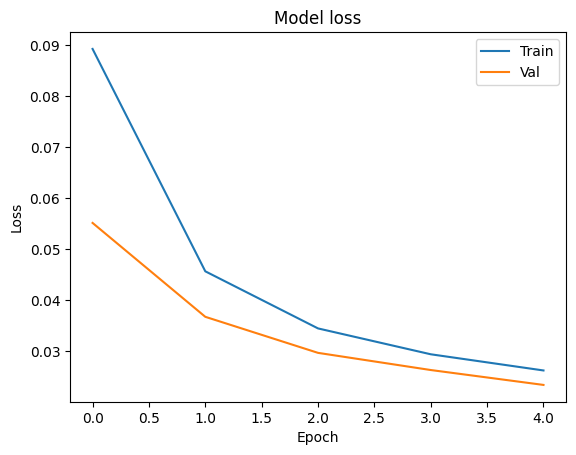

In [ ]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
print(predict('اكل محمد التفاحة',model2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
اكْلٌ مُحَمَّدِ التَّفَاحَةِ


In [ ]:
print(predict('الحمدلله رب العالمين',model2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
الْحَمْدَلِلَهُ رَبُّ الْعَالِمِينَ


### BiLSTM

This model architecture was taken by Fadel, Ali, Ibraheem et al.

In [ ]:
def create_model():
    # Creates diacritization model


    SelectedLSTM = LSTM

    inputs = Input(shape=(None,))

    embeddings = Embedding(input_dim=len(CHARACTERS_MAPPING),
                           output_dim=25,
                           embeddings_initializer=glorot_normal(seed=961))(inputs)

    blstm1 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(embeddings)
    dropout1 = Dropout(0.5)(blstm1)
    blstm2 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(dropout1)
    dropout2 = Dropout(0.5)(blstm2)

    dense1 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dropout2)
    dense2 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dense1)

    output = TimeDistributed(Dense(units=len(CLASSES_MAPPING),
                                   activation='softmax',
                                   kernel_initializer=glorot_normal(seed=961)))(dense2)

    model = Model(inputs, output)

    model.compile(loss='categorical_crossentropy', optimizer=Adam())

    return model

In [ ]:
model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 25)            │           1,925 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 512)           │         577,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 512)           │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 512)           │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 512)           │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 19)            │           9,747 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,689,432 (10.26 MB)

 Trainable params: 2,689,432 (10.26 MB)

 Non-trainable params: 0 (0.00 B)

Due to limited resource we decided to go with 2 epochs and batch size of 256 (we tried to run it with more epochs but it kept crashing)

In [ ]:
hist_1 = fit_model(model, 2, 256, train_split, val_split)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 1807s 6s/step - loss: 0.1366 - val_loss: 0.0471
Epoch 2/2
324/324 ━━━━━━━━━━━━━━━━━━━━ 1821s 6s/step - loss: 0.0422 - val_loss: 0.0284


In [ ]:
print('The loss value of the model after the training stage is :',hist_1.history['val_loss'][1])

The loss value of the model after the training stage is : 0.028357742354273796


In [ ]:
model.save("model1.h5")

In [ ]:
model.save_weights('model1.weights.h5')

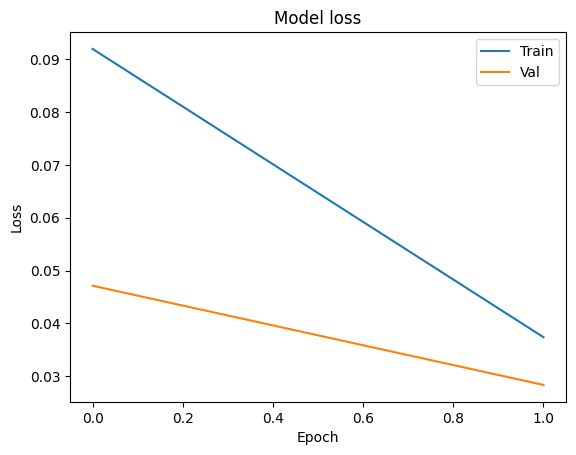

In [ ]:
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

As we go through the epochs, both training and validation loss decrease

In [ ]:
model = load_model('model1.h5')
model.load_weights('/content/model1.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
print(predict('اكل محمد التفاحة',model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
اكِلُ مُحَمَّدُ التَّفَاحَةِ


In [ ]:
print(predict('الحمدلله رب العالمين',model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
الْحَمْدِلُلُهُ رَبُّ الْعَالِمِيْنِ


## Evaluation For All **(run all cells until BiLSTM for this to work)**

In [ ]:
input_file = "arabic_data/test/test.txt"
output_file = "arabic_data/test/test_first_2000.txt"
input_file1 = "arabic_data/test/test_clean.txt"
output_file1 = "arabic_data/test/test_clean_first_2000.txt"

take_first_n_lines(input_file, output_file, n=2000)
take_first_n_lines(input_file1, output_file1, n=2000)

Successfully wrote first 2000 lines to arabic_data/test/test_first_2000.txt
Successfully wrote first 2000 lines to arabic_data/test/test_clean_first_2000.txt


In [ ]:
class BaseEvaluator:
    """Abstract base class for evaluation."""
    def load_model(self, model_path: str):
        raise NotImplementedError

    def predict(self, text: str) -> str:
        raise NotImplementedError

    def evaluate_text(self, gold: str, pred: str) -> dict:
        """
        Calculate WER and DER for a single pair of gold and predicted text.
        """
        wer = evaluate_word(gold, pred)
        der = self.calculate_der(gold, pred)
        return {"WER": wer, "DER": der}

    def calculate_der(self, gold: str, pred: str) -> float:
        """Custom implementation for calculating DER."""
        gold_pairs = word_iterator(gold)
        pred_pairs = word_iterator(pred)

        min_len = min(len(gold_pairs), len(pred_pairs))
        gold_pairs = gold_pairs[:min_len]
        pred_pairs = pred_pairs[:min_len]

        incorrect = sum(1 for (_, g_d), (_, p_d) in zip(gold_pairs, pred_pairs) if g_d != p_d)
        return incorrect / len(gold_pairs) if gold_pairs else 0.0


class CBHGHMMModelEvaluator(BaseEvaluator):
    def __init__(self, device: str = None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    def load_model(self, model_path: str):
        checkpoint = torch.load(model_path)
        self.model = CombinedDiacritizationModel(**checkpoint["model_config"])
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.model.to(self.device)
        self.model.eval()
        print(f"Loaded neural model from {model_path}")

    def predict(self, text: str) -> str:
        return self.model.predict(text)


class HMMModelEvaluator(BaseEvaluator):
    def __init__(self):
        self.hmm_model = HMM().load_trained_model("models/5gram_model.pkl")

    def predict(self, text: str) -> str:
        if not text:  # Handle None or empty text
            return ""
        return self.hmm_model.diacritize_word(text)

    def predict_sentence(self, text: str) -> str:
        if not text:  # Handle None or empty text
            return ""
        return self.hmm_model.diacritize_sentence(text)

class LSTMEvaluator(BaseEvaluator):
    def __init__(self, model_path: str, weights_path: str):
        """
        Initialize the LSTMEvaluator with the model and weights.
        """
        self.model_path = model_path
        self.weights_path = weights_path
        self.model = None
        self.load_model(model_path, weights_path)

    def load_model(self, model_path: str, weights_path: str):
        """
        Load the TensorFlow LSTM model and its weights.
        """
        self.model = load_model(model_path)
        self.model.load_weights(weights_path)
        print(f"Loaded LSTM model from {model_path} with weights {weights_path}")

    def predict(self, text: str) -> str:
        """
        Predict diacritization for the given text using the LSTM model.
        """
        if not text:  # Handle None or empty text
            return ""

        # Prepare data for the model (assumes map_data function is defined elsewhere)
        X, _ = map_data([text])
        predictions = self.model.predict(X).squeeze()[1:]  # Skip start token

        # Generate predicted text with diacritization
        output = ""
        for char, prediction in zip(remove_diacritics(text), predictions):
            output += char
            if char not in ARABIC_LETTERS_LIST:
                continue
            if '<' in REV_CLASSES_MAPPING[np.argmax(prediction)]:
                continue
            output += REV_CLASSES_MAPPING[np.argmax(prediction)]

        return output


class EvaluationPipeline:
    def __init__(self, evaluators: List[BaseEvaluator], test_sentences: Optional[List[str]] = None,
                 actual_sentences: Optional[List[str]] = None, test_file: Optional[str] = None,
                 actual_file: Optional[str] = None, max_samples: Optional[int] = None, use_sentences: bool = False):

        self.evaluators = evaluators
        self.test_sentences = test_sentences
        self.actual_sentences = actual_sentences
        self.test_file = test_file
        self.actual_file = actual_file
        self.max_samples = max_samples
        self.use_sentences = use_sentences

        # Load from files if sentences are not provided
        if self.use_sentences:
            if not self.test_sentences or not self.actual_sentences:
                raise ValueError("Both test_sentences and actual_sentences must be provided when use_sentences is True.")
        else:
            if not self.test_file or not self.actual_file:
                raise ValueError("Either test_sentences or test_file must be provided.")

            if not self.test_sentences:
                with open(self.test_file, 'r', encoding='utf-8') as test_f:
                    self.test_sentences = test_f.readlines()

            if not self.actual_sentences:
                with open(self.actual_file, 'r', encoding='utf-8') as actual_f:
                    self.actual_sentences = actual_f.readlines()

        # Trim sentences if max_samples is provided
        if self.max_samples:
            self.test_sentences = self.test_sentences[:self.max_samples]
            self.actual_sentences = self.actual_sentences[:self.max_samples]

    def evaluate(self):
        """
        Evaluate the models using the provided test and actual sentences.
        """
        # Ensure the number of test and actual sentences are the same
        if len(self.test_sentences) != len(self.actual_sentences):
            raise ValueError("The number of test sentences does not match the number of actual sentences.")

        # Evaluate for each evaluator
        for evaluator in self.evaluators:
            print(f"\nEvaluating with {type(evaluator).__name__}")
            results = []
            total_wer = 0
            total_der = 0

            for test_sentence, actual_sentence in zip(self.test_sentences, self.actual_sentences):
                test_sentence = test_sentence.strip() if test_sentence else None
                actual_sentence = actual_sentence.strip() if actual_sentence else None

                if not test_sentence or not actual_sentence:
                    continue  # Skip None or empty sentences

                if isinstance(evaluator, CBHGHMMModelEvaluator):
                    pred = evaluator.predict(test_sentence)
                elif isinstance(evaluator, HMMModelEvaluator) and self.test_sentences:
                    pred = evaluator.predict_sentence(test_sentence)
                else:
                  pred = evaluator.predict(test_sentence)
                metrics = evaluator.evaluate_text(actual_sentence, pred)

                total_wer += metrics["WER"]
                total_der += metrics["DER"]

                results.append({
                    "input": test_sentence,
                    "prediction": pred,
                    "actual": actual_sentence,
                    "metrics": metrics
                })

            # Calculate averages
            avg_wer = total_wer / len(results)
            avg_der = total_der / len(results)

            print(f"Average WER: {avg_wer:.4f}")
            print(f"Average DER: {avg_der:.4f}")

            # Save detailed results
            with open(f"{type(evaluator).__name__}_sentences{self.use_sentences}_results.json", "w", encoding="utf-8") as f:
                json.dump({"average_metrics": {"WER": avg_wer, "DER": avg_der}, "results": results}, f, ensure_ascii=False, indent=2)


# Load evaluators
neural_evaluator = CBHGHMMModelEvaluator()
neural_evaluator.load_model("final_model.pt")

hmm_evaluator = HMMModelEvaluator()

lstm_evaluator = LSTMEvaluator(
    model_path="model1.h5",
    weights_path="/content/model1.weights.h5"
)

lstm_evaluator2 = LSTMEvaluator(
    model_path="model2.h5",
    weights_path="/content/model2.weights.h5"
)

# Test sentences and actual sentences for direct input
test_sentences = [
    "اللغة العربية جميلة",
    "أنا أحب تعلم البرمجة",
    "هذا نص للاختبار"
]

actual_sentences = [
    "اللغة العربية رائعة",
    "أنا أستمتع بتعلم البرمجة",
    "هذا نص تجريبي للاختبار"
]

# Run evaluation pipeline with files
pipeline_with_files = EvaluationPipeline(
    evaluators=[neural_evaluator, hmm_evaluator, lstm_evaluator, lstm_evaluator2],
    test_file="arabic_data/test/test_clean_first_2000.txt",
    actual_file="arabic_data/test/test_first_2000.txt",
    max_samples=100
)
pipeline_with_files.evaluate()

# Run evaluation pipeline with direct sentences
pipeline_with_sentences = EvaluationPipeline(
    evaluators=[neural_evaluator, hmm_evaluator],
    test_sentences=test_sentences,
    actual_sentences=actual_sentences,
    use_sentences=True
)
pipeline_with_sentences.evaluate()

<ipython-input-44-7be8ff1f0dbe>:36: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Loaded existing 3-gram model
Loaded neural model from final_model.pt
Loaded existing 5-gram model
Loaded pre-trained 5-gram model from models/5gram_model.pkl


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 



Loaded LSTM model from model1.h5 with weights /content/model1.weights.h5
Loaded LSTM model from model2.h5 with weights /content/model2.weights.h5

Evaluating with CBHGHMMModelEvaluator
Average WER: 0.7918
Average DER: 0.2082

Evaluating with HMMModelEvaluator
Average WER: 0.8188
Average DER: 0.1812

Evaluating with LSTMEvaluator
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━